* [pytorch tutorials](https://pytorch.org/tutorials/)
* [torchaudio](https://pytorch.org/audio/stable/index.html)

In [2]:
# %%bash
# pip install torch==1.12.1
# pip install torchaudio==0.12.1
# pip install omegaconf==2.2.3
# pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git

# mkdir ./data
# wget -q https://raw.githubusercontent.com/karpnv/speech-tech-mipt/week5/week05/data/8b427e83c196b517cd240822a18ba698.wav -P ./data

In [3]:
import random
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Optional, Callable, Dict, List, Any, Tuple

import omegaconf
import torch
from torch.utils.tensorboard import SummaryWriter
import torchaudio
import thop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import IPython.display as ipd

In [4]:
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
@dataclass
class Model:
    kernels: Tuple[int]
    strides: Tuple[int]
    channels: Tuple[int]
    hidden_size: int
    activation: str

@dataclass
class Optim:
    lr: float
    n_epochs: int
    batch_size: int
        
@dataclass
class Features:
    n_fft: int
    win_length: int
    hop_length: int
    n_mels: int

@dataclass
class Augmentations:
    freq_mask_param: int
    time_mask_param: int

In [6]:
@dataclass
class ExpConfig:
    sample_rate: int = 16_000
    val_fraction: float = 0.1
    idx_to_keyword: List[str] = ('sber', 'joy', 'afina', 'salut', 'filler')
    device: str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    model: Model = Model(
        kernels=(3, 3), strides=(2, 2), channels=(32, 32), hidden_size=16, activation='ReLU'
    )
    optim: Optim = Optim(
        lr=1e-3, n_epochs=10, batch_size=64
    )
    features: Features = Features(
        n_fft=400, win_length=400, hop_length=160, n_mels=64
    )
    augs: Augmentations = Augmentations(
        freq_mask_param=0, time_mask_param=0
    )

In [7]:
conf = omegaconf.OmegaConf.structured(ExpConfig)

# Data

download from [kaggle](https://www.kaggle.com/t/830d20b353bd4e0d80630a97835f14a6)

In [8]:
%%bash
rm -rf test train
unzip -q train.zip
unzip -q test.zip

# Dataset

In [9]:
class SpecScaler(torch.nn.Module):
    def forward(self, x):
        return torch.log(x.clamp_(1e-9, 1e9))

In [10]:
class SpotterDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, manifest_path: Path, idx_to_keyword: List[str],
            transform, ids: Optional[List[int]] = None
        ):
        super().__init__()
        
        self.transform = transform
        
        manifest = pd.read_csv(manifest_path)
        if ids is not None:
            manifest = manifest.loc[ids]
        self.wav_files = [
            manifest_path.parent / wav_path for wav_path in manifest.path
        ]
        
        keyword_to_idx = {
            keyword: idx for idx, keyword in enumerate(idx_to_keyword)
        }
        self.labels = [
            keyword_to_idx[keyword] for keyword in manifest.label
        ]
        
    def __len__(self):
        return len(self.wav_files)
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wav_files[idx])
        features = self.transform(wav)
        return wav[0], features, self.labels[idx]

In [11]:
dataset = SpotterDataset(
    manifest_path=Path("train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=torch.nn.Sequential(
        torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
        torchaudio.transforms.FrequencyMasking(freq_mask_param=conf.augs.freq_mask_param),
        torchaudio.transforms.TimeMasking(time_mask_param=conf.augs.time_mask_param),
        SpecScaler()
    )
)

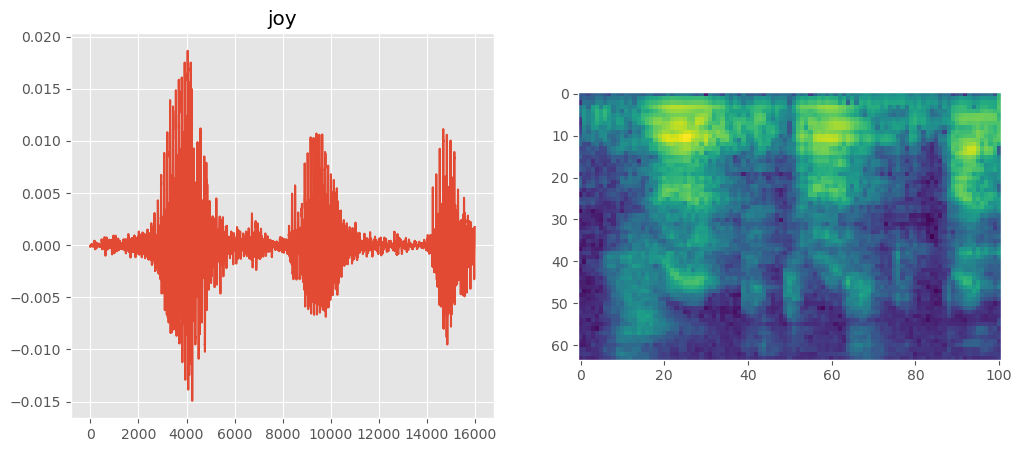

In [12]:
wav, features, label = next(iter(dataset))

ipd.display(ipd.Audio(wav, rate=conf.sample_rate))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(conf.idx_to_keyword[label])
plt.plot(wav)
plt.subplot(122)
plt.grid()
plt.imshow(features[0])
plt.show()

In [13]:
def collator(data):
    specs = []
    labels = []

    for wav, features, label in data:
        specs.append(features)
        labels.append(label)

    specs = torch.cat(specs)  
    labels = torch.Tensor(labels).long()
    return specs, labels

# Train Loop

In [14]:
def train_one_epoch(model, criterion, optimizer, loader, device, epoch_index, tb_writer, log_interval=100):
    
    model.train()
    
    running_loss = 0.
    running_true_preds, running_preds = 0, 0
    last_loss, last_acc = 0., 0.

    for i, (inputs, labels) in enumerate(loader):
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logprobs = model(inputs)
        preds = logprobs.argmax(1)
        loss = criterion(logprobs, labels)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        running_true_preds += (preds == labels).sum()
        running_preds += torch.numel(preds)
        
        if i % log_interval == log_interval - 1:
            last_loss = running_loss / log_interval
            last_acc = running_true_preds / running_preds 
            tb_x = epoch_index * len(loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Accuracy/train', last_acc, tb_x)
            running_loss = 0.
            running_true_preds, running_preds = 0, 0

    return last_loss, last_acc


@torch.no_grad()
def validation(model, criterion, loader, device, epoch_index, tb_writer):
    
    model.eval()
    
    running_loss = 0.
    running_true_preds, running_preds = 0, 0

    for i, (inputs, labels) in enumerate(loader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        logprobs = model(inputs)
        preds = logprobs.argmax(1)
        
        running_loss += criterion(logprobs, labels).item()
        running_true_preds += (preds == labels).sum()
        running_preds += torch.numel(preds)
        
    loss = running_loss / len(loader)
    acc = running_true_preds / running_preds 
    
    tb_x = epoch_index + 1
    tb_writer.add_scalar('Loss/val', loss, tb_x)
    tb_writer.add_scalar('Accuracy/val', acc, tb_x)
    
    return loss, acc

# Model

In [15]:
class Conv1dNet(torch.nn.Module):
    
    def __init__(self, in_features, n_classes, conf: omegaconf.dictconfig.DictConfig):
        
        super().__init__()
        
        activation = getattr(torch.nn, conf.activation)()
        
        features = in_features
        
        module_list = []
        
        for kernel_size, stride, channels in zip(conf.kernels, conf.strides, conf.channels):
            
            module_list.extend([
                torch.nn.Conv1d(
                    in_channels=features, out_channels=channels, kernel_size=kernel_size,
                    stride=stride, groups=channels
                ),
                activation,
                torch.nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=1),
                torch.nn.BatchNorm1d(num_features=channels),
                activation,
                torch.nn.MaxPool1d(kernel_size=stride)
            ])
            
            features = channels

        module_list.extend([
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),

            torch.nn.Linear(channels, conf.hidden_size),
            activation,
            torch.nn.Linear(conf.hidden_size, n_classes),
            torch.nn.LogSoftmax(-1)
        ])
        
        self.model = torch.nn.Sequential(*module_list)
        
    def forward(self, x):
        return self.model(x)

In [16]:
model = Conv1dNet(
    in_features=conf.features.n_mels, 
    n_classes=len(conf.idx_to_keyword),
    conf=conf.model
)

In [17]:
thop.profile(
    model, inputs=(torch.randn(1, 64, 101),)
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


(82992.0, 3205.0)

# Experiments

In [18]:
@dataclass
class ExpConfig:
    sample_rate: int = 16_000
    val_fraction: float = 0.1
    idx_to_keyword: List[str] = ('sber', 'joy', 'afina', 'salut', 'filler')
    device: str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    model: Model = Model(
        kernels=(3, 3), strides=(2, 2), channels=(32, 32), hidden_size=16, activation='ReLU'
    )
    optim: Optim = Optim(
        lr=1e-3, n_epochs=10, batch_size=64
    )
    features: Features = Features(
        n_fft=400, win_length=400, hop_length=160, n_mels=64
    )
    augs: Augmentations = Augmentations(
        freq_mask_param=0, time_mask_param=0
    )

In [19]:
conf = omegaconf.OmegaConf.structured(ExpConfig)

In [20]:
train_transform = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=conf.augs.freq_mask_param),
    torchaudio.transforms.TimeMasking(time_mask_param=conf.augs.time_mask_param),
    SpecScaler()
)

val_transform = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
    SpecScaler()
)

In [21]:
val_count = int(len(dataset) * conf.val_fraction)
ids = torch.randperm(len(dataset), generator=torch.Generator().manual_seed(SEED))

val_ids = ids[:val_count]
train_ids = ids[val_count:]

train_dataset = SpotterDataset(
    manifest_path=Path("train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=train_transform,
    ids=train_ids
)

val_dataset = SpotterDataset(
    manifest_path=Path("train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=val_transform,
    ids=val_ids
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=conf.optim.batch_size,
    shuffle=False,
    collate_fn=collator
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=conf.optim.batch_size,
    shuffle=False,
    collate_fn=collator
)

In [22]:
model = (
    Conv1dNet(
        in_features=conf.features.n_mels, 
        n_classes=len(conf.idx_to_keyword),
        conf=conf.model
    )
    .to(conf.device)
)
optimizer = torch.optim.Adam(params=model.parameters(), lr=conf.optim.lr)
criterion = torch.nn.NLLLoss()

macs, params = thop.profile(
    model, inputs=(
        torch.randn(1, conf.features.n_mels, conf.sample_rate // conf.features.hop_length + 1)
        .to(conf.device)
        ,
    )
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [23]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

exp_dir = Path(f"runs/{timestamp}")
ckpt_dir = exp_dir / "ckpts"
ckpt_dir.mkdir(parents=True)
with open(exp_dir / 'conf.yaml', 'w') as f:
    omegaconf.OmegaConf.save(config=conf, f=f)

tb_writer = SummaryWriter(exp_dir)

tb_writer.add_scalar('MACs', macs, 0)
tb_writer.add_scalar('Params', params, 0)

best_val_acc = -1.

for epoch in range(conf.optim.n_epochs):
    
    avg_loss, avg_acc  = train_one_epoch(
        model, criterion, optimizer, train_dataloader,
        conf.device, epoch, tb_writer
    )
    
    val_loss, val_acc = validation(
        model, criterion, val_dataloader,
        conf.device, epoch, tb_writer
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            model.state_dict(),
            ckpt_dir / f"model_epoch_{epoch + 1}_val_acc_{val_acc:.3f}.ckpt"
        )

# Error Analysis

In [24]:
# iter through val_dataloader
# plot confusion matrix
# listen to misclassification

# Submit

In [25]:
class TestSpotterDataset(torch.utils.data.Dataset):
    def __init__(self, manifest_path: Path, transform):
        super().__init__()
        
        self.transform = transform
        manifest = pd.read_csv(manifest_path)
        self.wav_files = [
            manifest_path.parent / wav_path for wav_path in manifest.path
        ]
        self.labels = manifest.index.values
        
    def __len__(self):
        return len(self.wav_files)
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wav_files[idx])
        features = self.transform(wav)
        return wav[0], features, self.labels[idx]

In [26]:
model.eval()

test_dataloader = torch.utils.data.DataLoader(
    dataset=TestSpotterDataset(
        manifest_path=Path('test/manifest.csv'),
        transform=val_transform
    ),
    collate_fn=collator,
    batch_size=conf.optim.batch_size,
    shuffle=False
)

In [27]:
index_lst, label_lst = [], []

for inputs, idx in test_dataloader:
    
    with torch.no_grad():
        preds = model(inputs.to(conf.device)).argmax(-1).cpu().tolist()
    
    label_lst.extend([conf.idx_to_keyword[idx] for idx in preds])
    index_lst.extend(idx.tolist())

In [28]:
(
    pd.DataFrame({'index': index_lst, 'label': label_lst})
    .to_csv('submit.csv', index=False)
)

# Long Audio Inference

In [29]:
!soxi ./data/8b427e83c196b517cd240822a18ba698.wav


Input File     : './data/8b427e83c196b517cd240822a18ba698.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:19.15 = 306406 samples ~ 1436.28 CDDA sectors
File Size      : 613k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



{'sber': 0.0023825471, 'joy': 0.010561863, 'afina': 0.14002942, 'salut': 0.7217252, 'filler': 0.12530091}


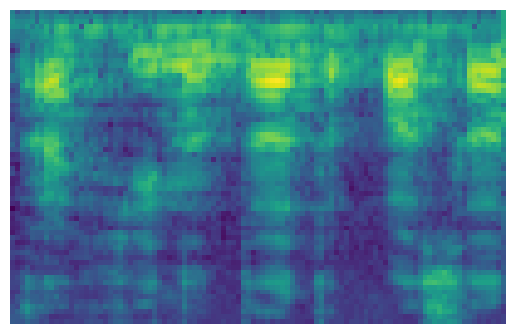

{'sber': 0.027274923, 'joy': 0.0011876907, 'afina': 0.18337202, 'salut': 0.44731084, 'filler': 0.3408545}


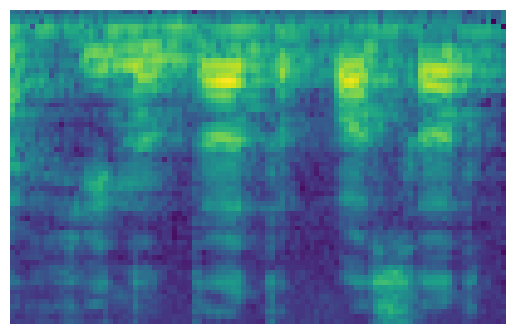

{'sber': 0.057954803, 'joy': 0.031200947, 'afina': 0.7233812, 'salut': 0.0053231926, 'filler': 0.18213986}


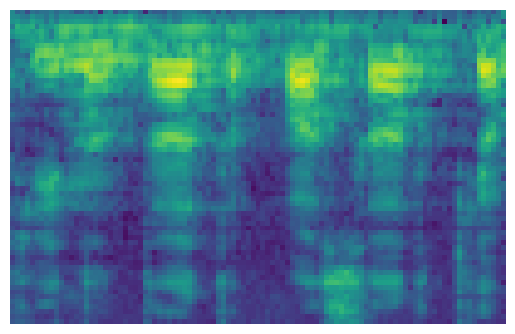

{'sber': 0.0044687293, 'joy': 0.0040676217, 'afina': 0.0016820539, 'salut': 0.0021459833, 'filler': 0.98763555}


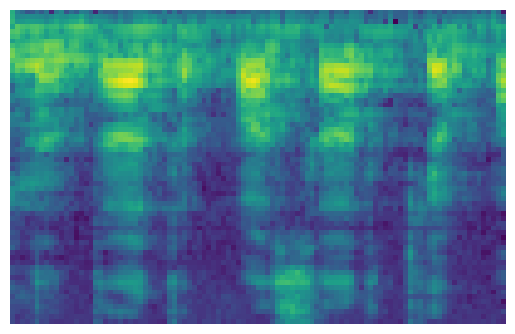

{'sber': 0.0019739855, 'joy': 0.029667608, 'afina': 0.0016477206, 'salut': 0.24203639, 'filler': 0.7246743}


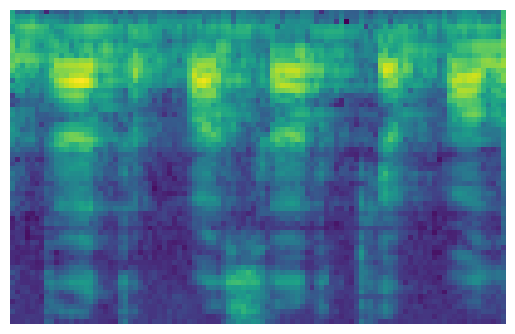

{'sber': 0.030617788, 'joy': 0.0091625145, 'afina': 0.0034418628, 'salut': 0.7800945, 'filler': 0.1766833}


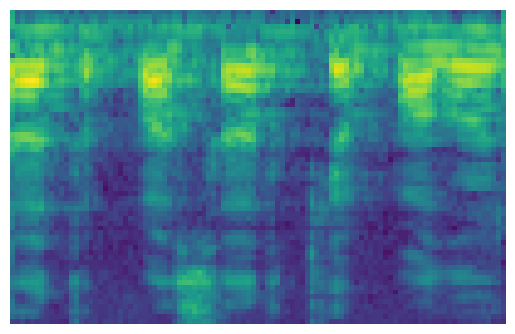

{'sber': 0.036924917, 'joy': 0.0038057985, 'afina': 0.0064441236, 'salut': 0.5042542, 'filler': 0.44857094}


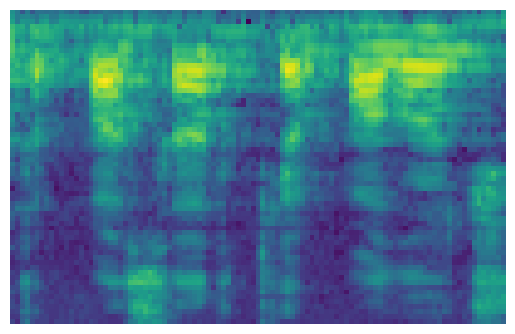

{'sber': 0.0023690255, 'joy': 0.0011424442, 'afina': 0.01256001, 'salut': 0.0031826382, 'filler': 0.9807459}


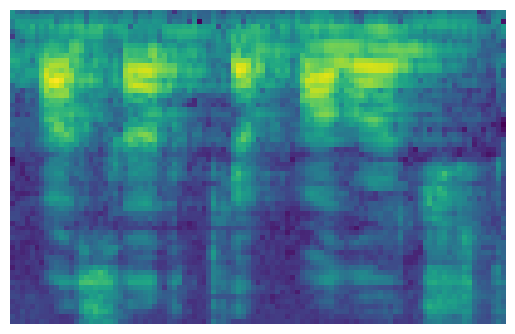

{'sber': 0.0007226456, 'joy': 0.020670906, 'afina': 0.00047360538, 'salut': 0.018635347, 'filler': 0.95949745}


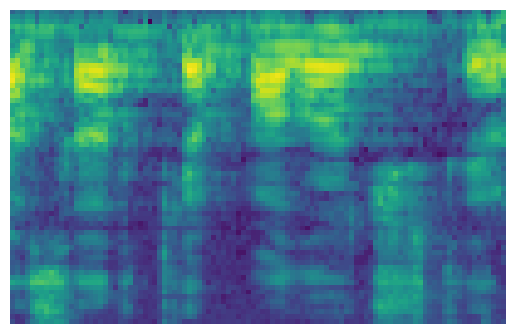

{'sber': 0.0027974902, 'joy': 0.11226617, 'afina': 0.00079268945, 'salut': 0.4903582, 'filler': 0.39378545}


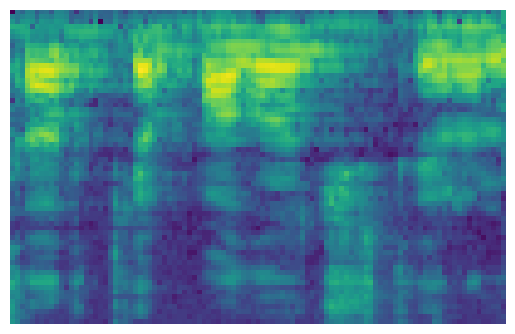

{'sber': 0.00624211, 'joy': 0.06669124, 'afina': 0.02314583, 'salut': 0.08493934, 'filler': 0.8189815}


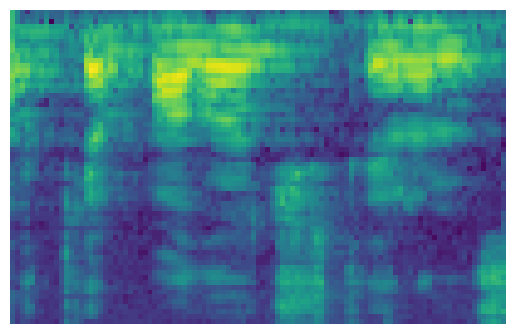

{'sber': 0.0073582795, 'joy': 0.0011978411, 'afina': 0.0005765586, 'salut': 0.013631104, 'filler': 0.97723615}


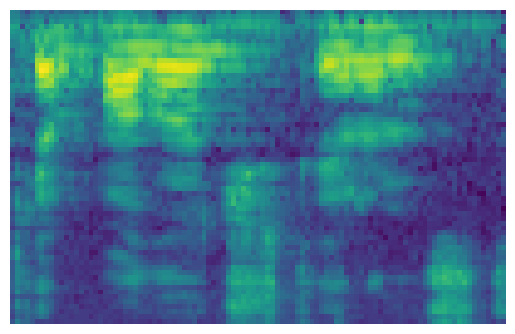

{'sber': 0.0009026052, 'joy': 0.0033263278, 'afina': 0.00096122746, 'salut': 0.001294117, 'filler': 0.99351573}


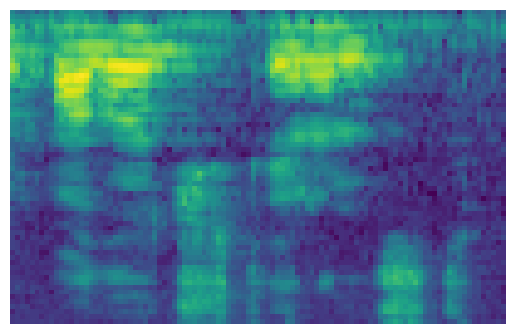

{'sber': 0.001206344, 'joy': 0.002155627, 'afina': 0.0013334285, 'salut': 0.001088664, 'filler': 0.9942159}


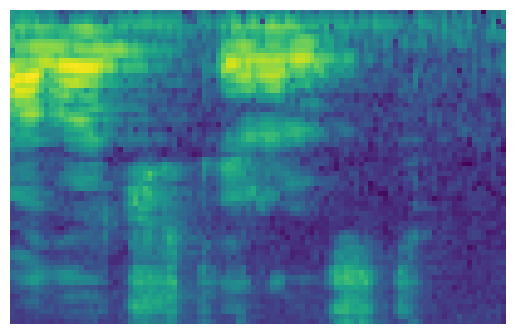

{'sber': 0.015092098, 'joy': 0.0069929087, 'afina': 0.0029249291, 'salut': 0.031968802, 'filler': 0.9430213}


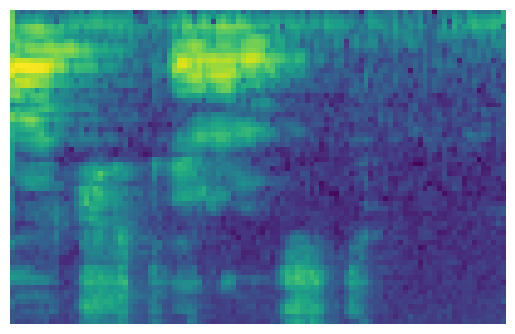

{'sber': 0.0025911755, 'joy': 0.001073657, 'afina': 0.0009800504, 'salut': 0.00285563, 'filler': 0.99249953}


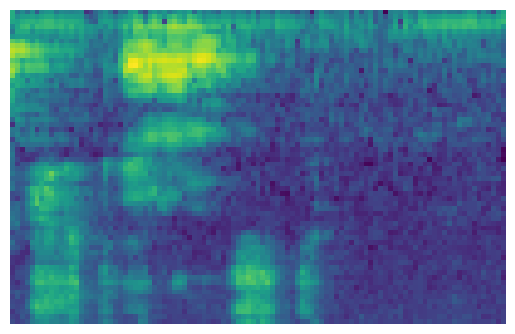

{'sber': 0.0036009972, 'joy': 0.004016354, 'afina': 0.0012437784, 'salut': 0.004561602, 'filler': 0.9865773}


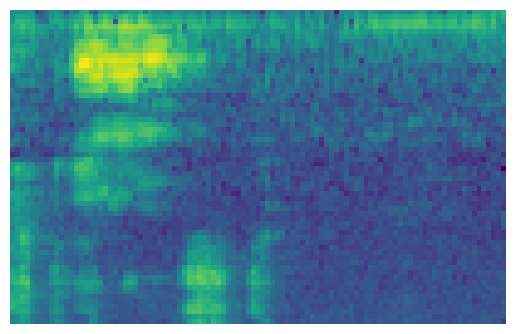

{'sber': 0.009771457, 'joy': 0.04028701, 'afina': 0.0027546182, 'salut': 0.004378835, 'filler': 0.94280803}


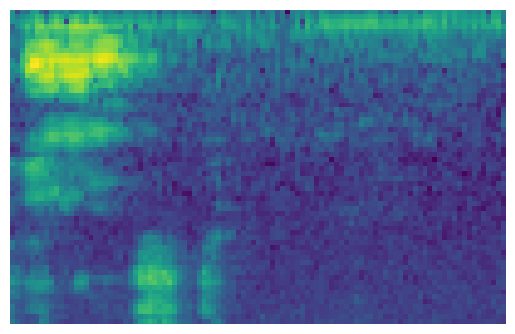

{'sber': 0.011537315, 'joy': 0.012333628, 'afina': 0.0070026754, 'salut': 0.009737851, 'filler': 0.9593885}


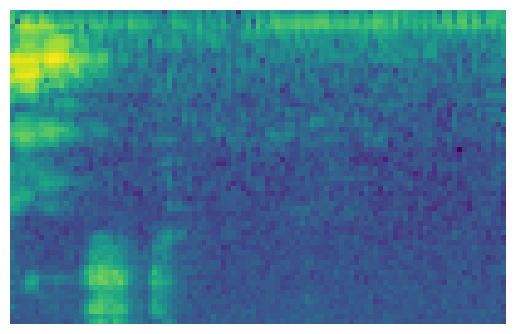

{'sber': 0.007991787, 'joy': 0.005693591, 'afina': 0.0031072274, 'salut': 0.002733729, 'filler': 0.98047364}


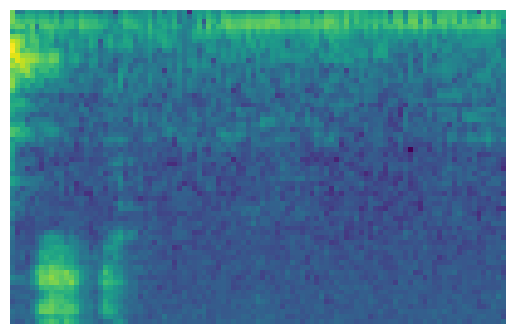

{'sber': 0.03602584, 'joy': 0.030404424, 'afina': 0.009772431, 'salut': 0.013569203, 'filler': 0.91022813}


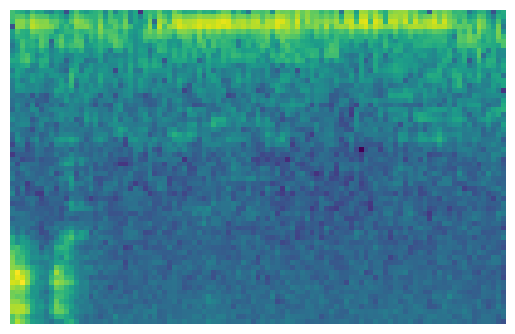

{'sber': 0.06719516, 'joy': 0.068559274, 'afina': 0.029842706, 'salut': 0.037287146, 'filler': 0.7971157}


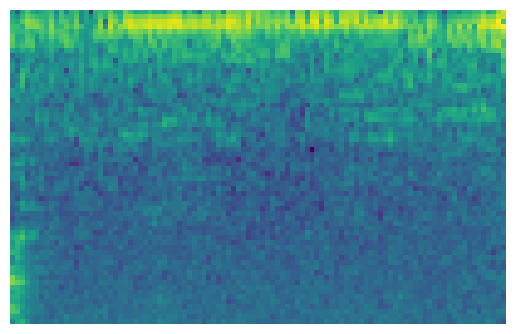

{'sber': 0.10799791, 'joy': 0.12352562, 'afina': 0.051534615, 'salut': 0.06749654, 'filler': 0.64944535}


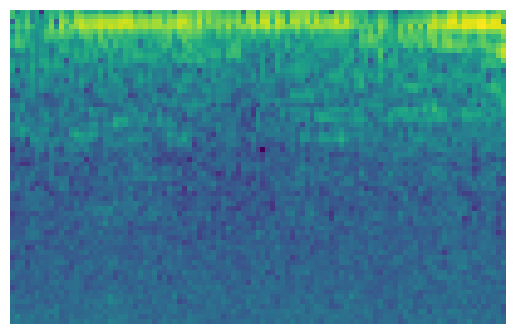

{'sber': 0.051699523, 'joy': 0.063383564, 'afina': 0.0358809, 'salut': 0.048055142, 'filler': 0.8009808}


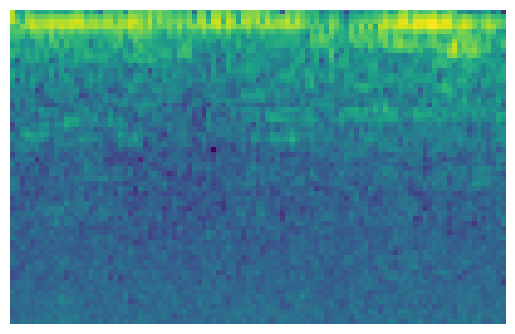

{'sber': 0.03613093, 'joy': 0.037572104, 'afina': 0.012759432, 'salut': 0.02132004, 'filler': 0.89221746}


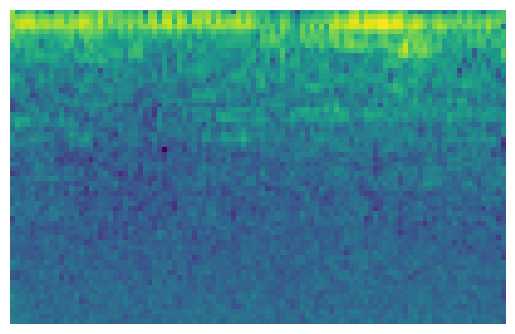

{'sber': 0.065858155, 'joy': 0.088005535, 'afina': 0.034735303, 'salut': 0.04763193, 'filler': 0.76376903}


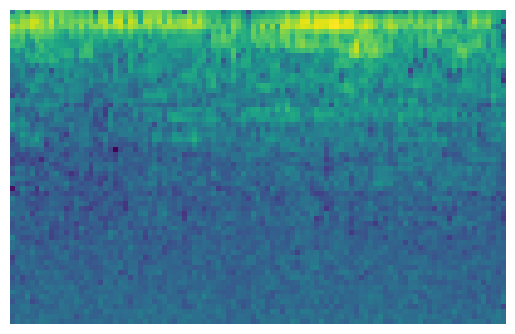

{'sber': 0.017431702, 'joy': 0.028217157, 'afina': 0.012649903, 'salut': 0.026507111, 'filler': 0.9151941}


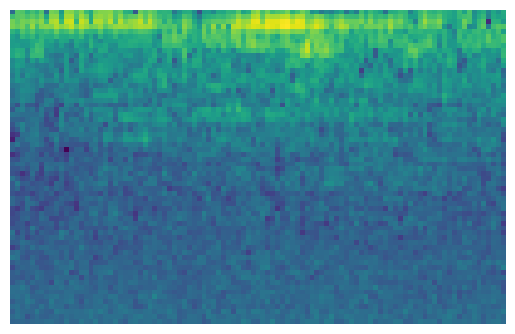

{'sber': 0.034899283, 'joy': 0.038542036, 'afina': 0.017501013, 'salut': 0.02834037, 'filler': 0.88071734}


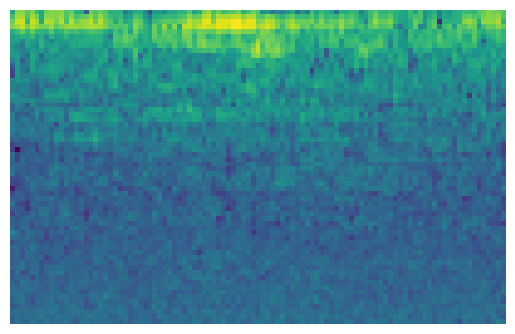

{'sber': 0.13029194, 'joy': 0.16605054, 'afina': 0.065854765, 'salut': 0.09525528, 'filler': 0.5425475}


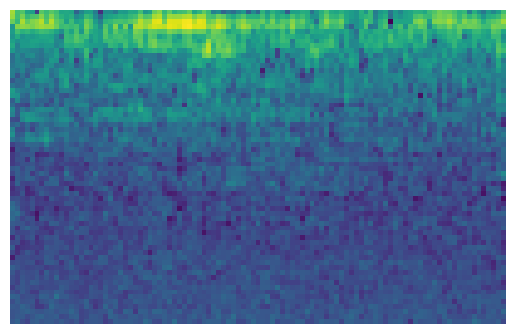

{'sber': 0.06035157, 'joy': 0.066014245, 'afina': 0.030230166, 'salut': 0.041609336, 'filler': 0.8017947}


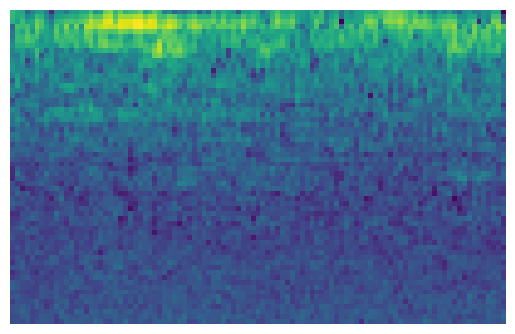

{'sber': 0.011814891, 'joy': 0.01536802, 'afina': 0.007975105, 'salut': 0.013424656, 'filler': 0.95141727}


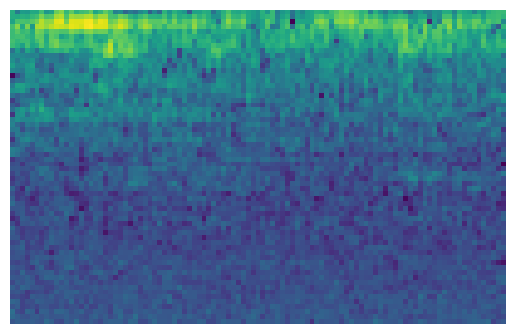

{'sber': 0.087127954, 'joy': 0.13150582, 'afina': 0.043081168, 'salut': 0.07488145, 'filler': 0.6634037}


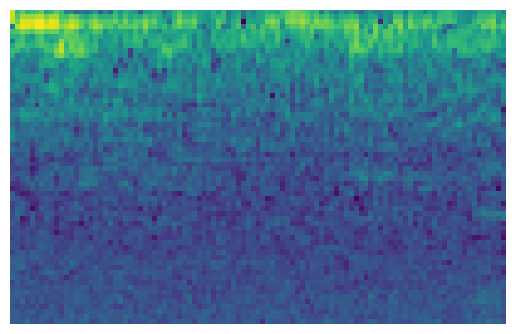

{'sber': 0.11678519, 'joy': 0.17959051, 'afina': 0.05433544, 'salut': 0.096176624, 'filler': 0.5531122}


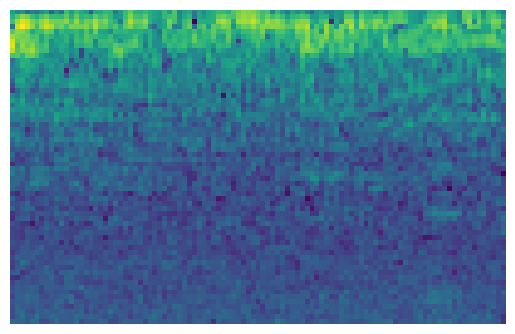

{'sber': 0.02551761, 'joy': 0.022094885, 'afina': 0.0112426365, 'salut': 0.014781592, 'filler': 0.9263633}


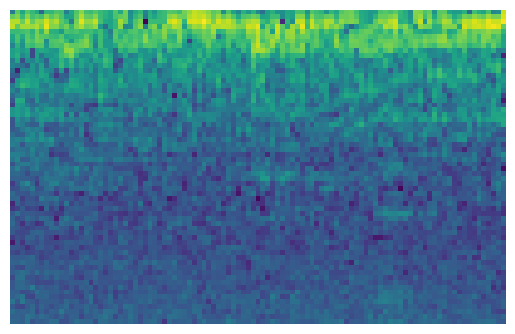

{'sber': 0.03777465, 'joy': 0.051565368, 'afina': 0.018180786, 'salut': 0.0329526, 'filler': 0.8595266}


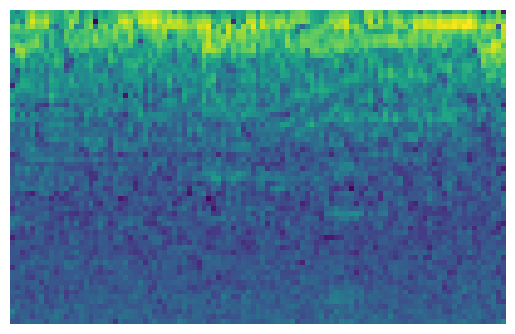

{'sber': 0.12393578, 'joy': 0.20667025, 'afina': 0.06482947, 'salut': 0.11036575, 'filler': 0.4941987}


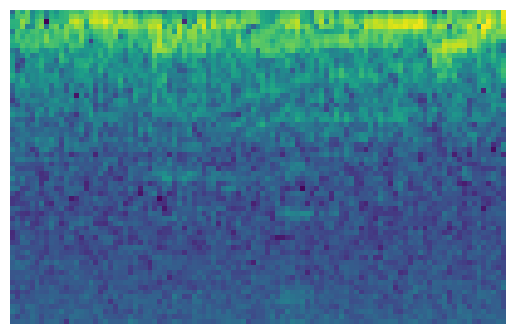

{'sber': 0.036949374, 'joy': 0.048847187, 'afina': 0.014291556, 'salut': 0.024413103, 'filler': 0.8754988}


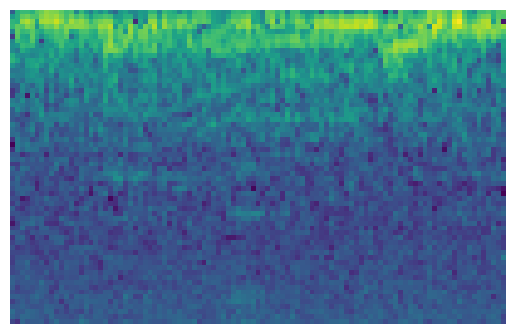

{'sber': 0.0081493445, 'joy': 0.0058323527, 'afina': 0.0037008063, 'salut': 0.0039987946, 'filler': 0.97831863}


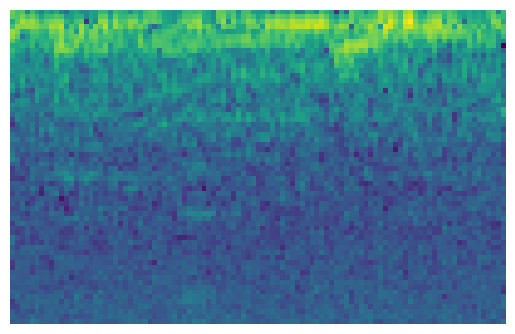

{'sber': 0.07143294, 'joy': 0.112976454, 'afina': 0.04040086, 'salut': 0.07164671, 'filler': 0.703543}


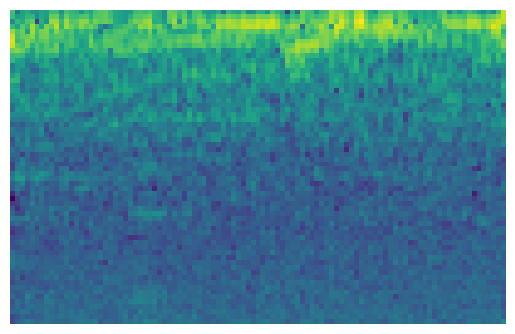

{'sber': 0.13173395, 'joy': 0.18345109, 'afina': 0.07711047, 'salut': 0.09746355, 'filler': 0.5102409}


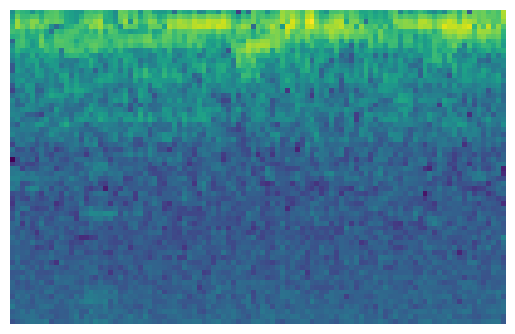

{'sber': 0.02637916, 'joy': 0.03036671, 'afina': 0.014011677, 'salut': 0.02005897, 'filler': 0.9091835}


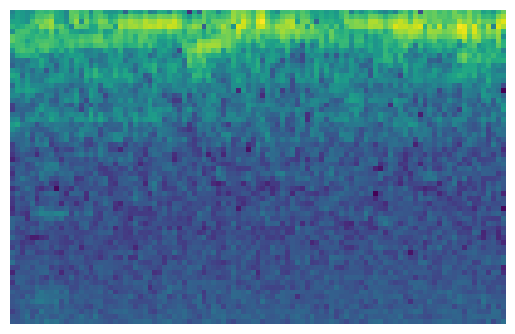

{'sber': 0.018125731, 'joy': 0.012912194, 'afina': 0.015871339, 'salut': 0.013360291, 'filler': 0.9397304}


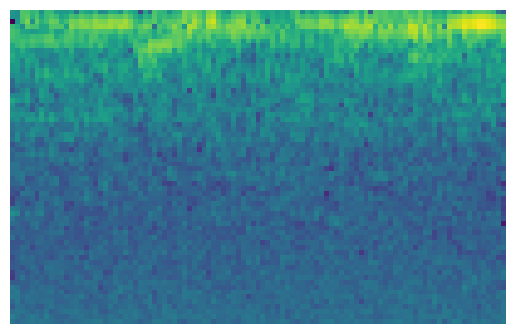

{'sber': 0.025638973, 'joy': 0.032859668, 'afina': 0.01593917, 'salut': 0.025873741, 'filler': 0.8996885}


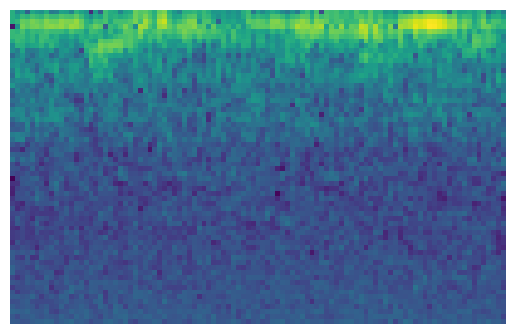

{'sber': 0.028279427, 'joy': 0.035338122, 'afina': 0.01394362, 'salut': 0.023744386, 'filler': 0.89869446}


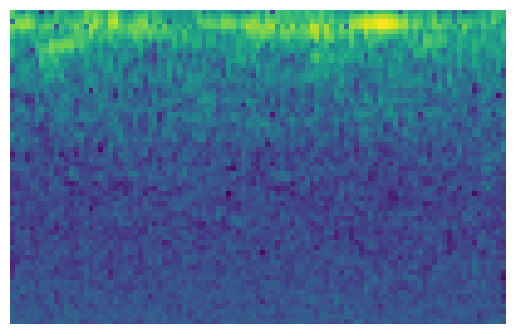

{'sber': 0.02529222, 'joy': 0.05116313, 'afina': 0.011823227, 'salut': 0.029653352, 'filler': 0.88206804}


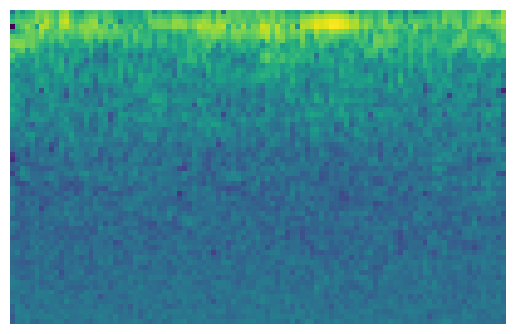

{'sber': 0.045194235, 'joy': 0.04850931, 'afina': 0.029642537, 'salut': 0.037346125, 'filler': 0.83930784}


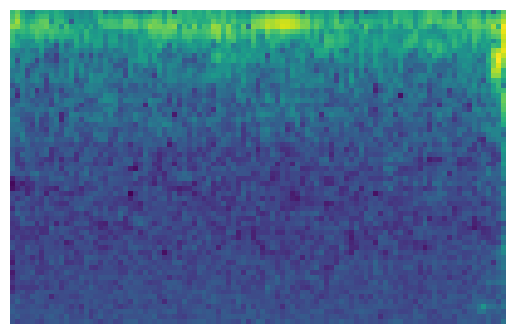

{'sber': 0.08011656, 'joy': 0.04427862, 'afina': 0.054346647, 'salut': 0.034310937, 'filler': 0.78694725}


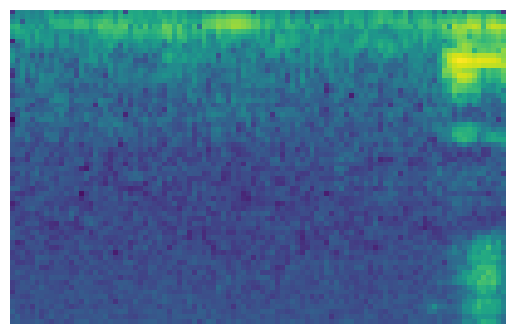

{'sber': 0.15645948, 'joy': 0.060193457, 'afina': 0.03529963, 'salut': 0.018462313, 'filler': 0.7295851}


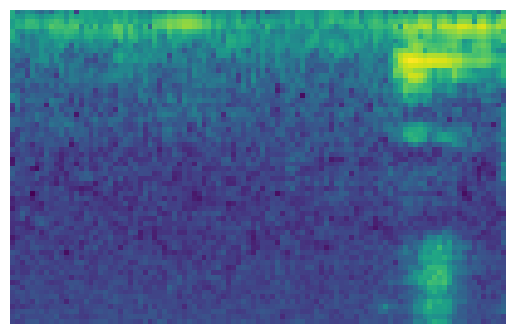

{'sber': 0.8157154, 'joy': 0.060685277, 'afina': 0.005078707, 'salut': 0.0069367923, 'filler': 0.11158384}


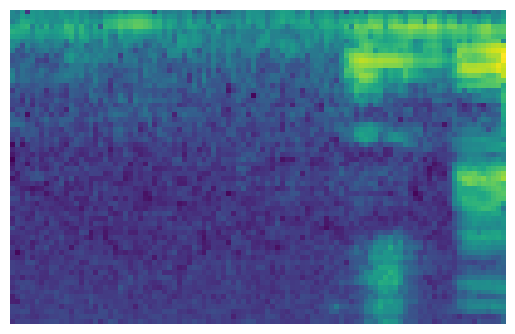

{'sber': 0.8709906, 'joy': 0.07931977, 'afina': 0.0043366076, 'salut': 0.00021816378, 'filler': 0.04513489}


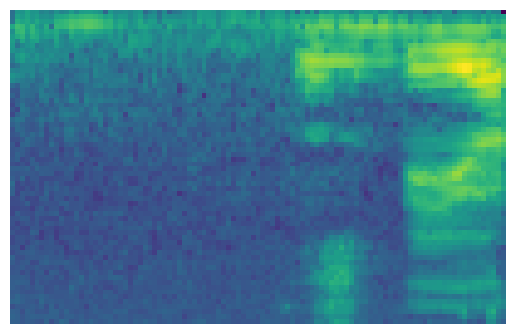

{'sber': 0.9205937, 'joy': 0.019157784, 'afina': 0.0049603917, 'salut': 6.331291e-05, 'filler': 0.055224847}


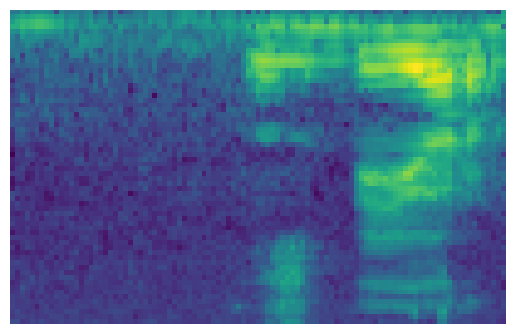

{'sber': 0.92409134, 'joy': 0.002927812, 'afina': 0.0013857174, 'salut': 0.00018559623, 'filler': 0.071409516}


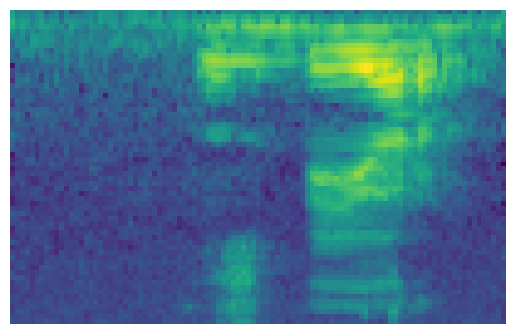

{'sber': 0.6448765, 'joy': 0.017164985, 'afina': 0.00088933436, 'salut': 9.879528e-05, 'filler': 0.33697036}


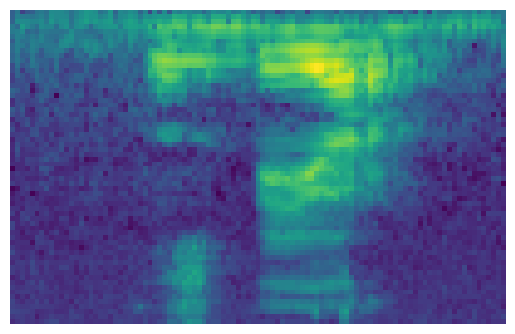

{'sber': 0.92018986, 'joy': 0.0036218064, 'afina': 0.0028227565, 'salut': 4.8688067e-05, 'filler': 0.0733169}


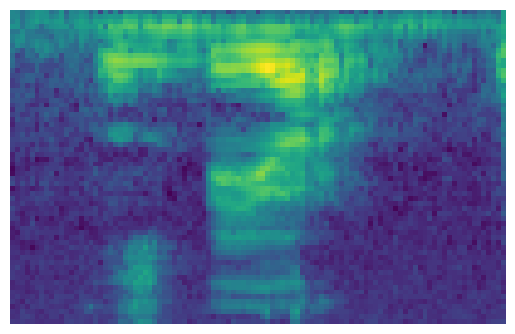

{'sber': 0.922962, 'joy': 0.027738016, 'afina': 0.0036941525, 'salut': 0.00046769436, 'filler': 0.045138128}


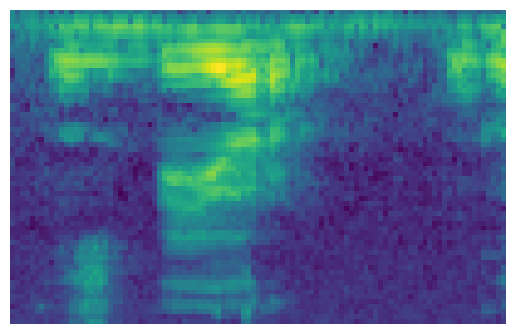

{'sber': 0.9849726, 'joy': 0.0037630545, 'afina': 0.0005904033, 'salut': 4.5350294e-05, 'filler': 0.010628724}


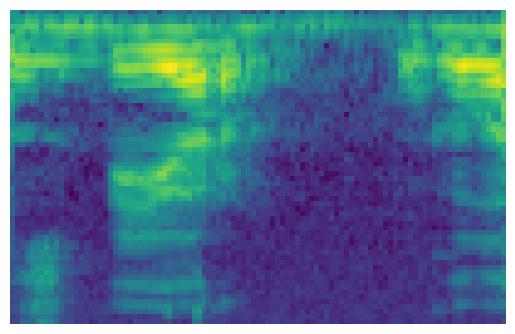

{'sber': 0.96288824, 'joy': 0.003521959, 'afina': 0.00073061814, 'salut': 0.000627296, 'filler': 0.032231912}


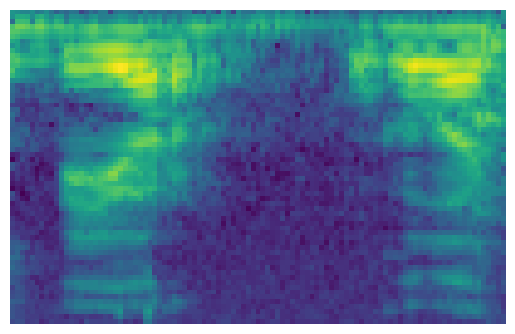

{'sber': 0.39207372, 'joy': 0.05996439, 'afina': 0.0113853365, 'salut': 0.0022850847, 'filler': 0.53429145}


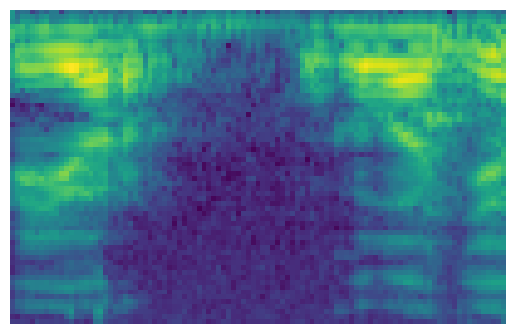

{'sber': 0.0041026864, 'joy': 0.006949489, 'afina': 0.047217533, 'salut': 0.006330908, 'filler': 0.93539935}


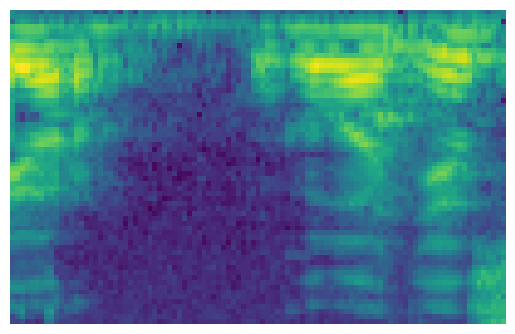

{'sber': 0.0044657663, 'joy': 0.034287058, 'afina': 0.027814949, 'salut': 0.08513868, 'filler': 0.84829354}


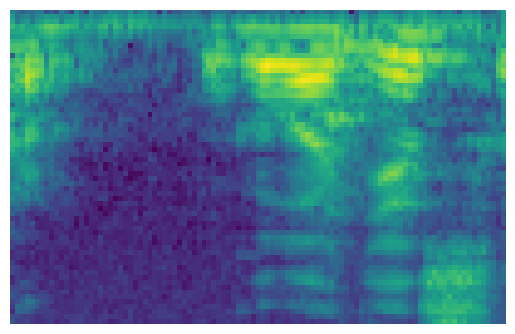

{'sber': 0.044557404, 'joy': 0.011575122, 'afina': 0.005542254, 'salut': 0.009332908, 'filler': 0.9289923}


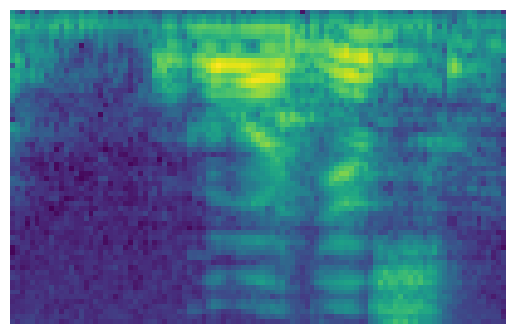

{'sber': 0.03074126, 'joy': 0.019191971, 'afina': 0.0061585004, 'salut': 0.011432432, 'filler': 0.93247586}


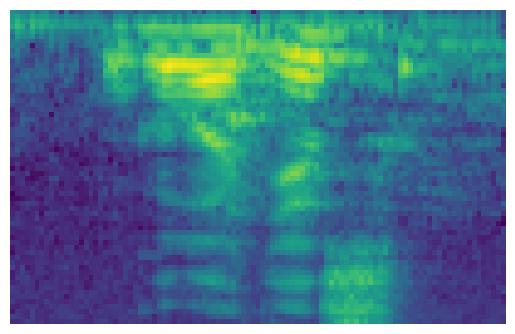

{'sber': 0.16978325, 'joy': 0.21874063, 'afina': 0.010508914, 'salut': 0.034333415, 'filler': 0.56663376}


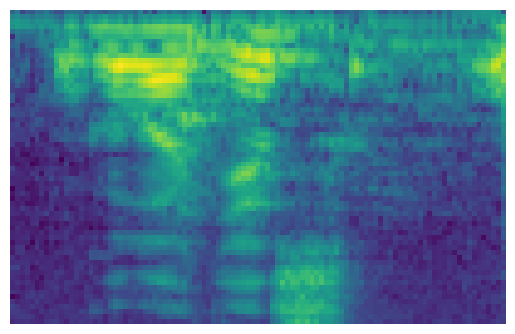

{'sber': 0.05455687, 'joy': 0.10382973, 'afina': 0.030160371, 'salut': 0.07074271, 'filler': 0.7407103}


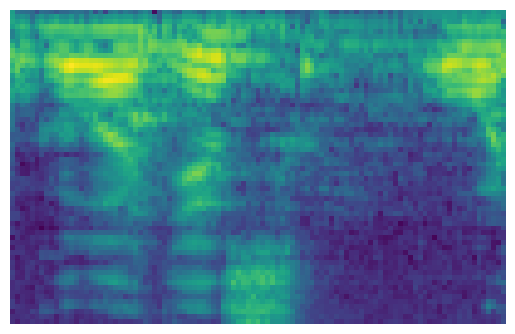

{'sber': 0.02256524, 'joy': 0.002999665, 'afina': 0.002144993, 'salut': 0.011234952, 'filler': 0.9610551}


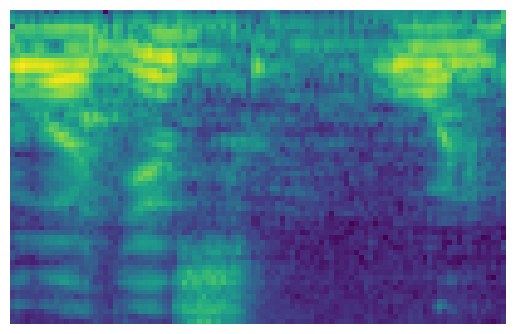

{'sber': 0.08693075, 'joy': 0.07354609, 'afina': 0.003124362, 'salut': 0.021578303, 'filler': 0.8148205}


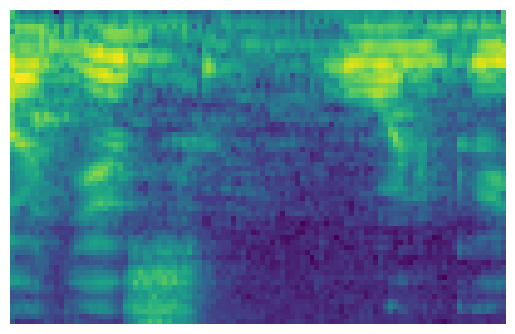

{'sber': 0.0047120256, 'joy': 0.035852425, 'afina': 0.008035842, 'salut': 0.13193421, 'filler': 0.8194655}


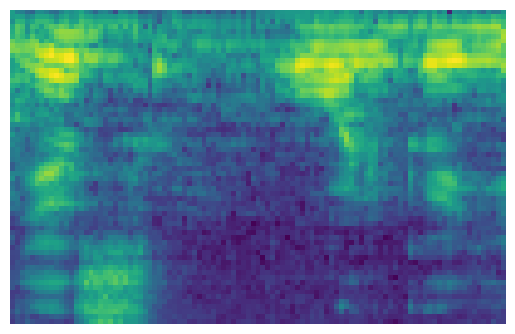

{'sber': 0.120297655, 'joy': 0.09885575, 'afina': 0.008480793, 'salut': 0.020669816, 'filler': 0.751696}


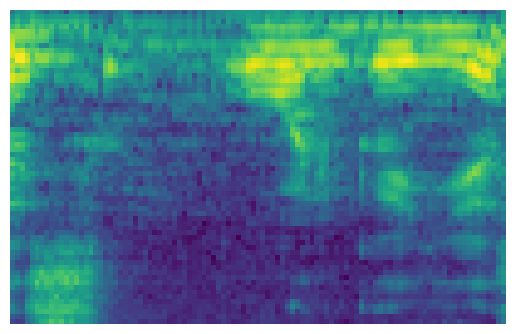

{'sber': 0.2733775, 'joy': 0.039141726, 'afina': 0.0019972646, 'salut': 0.0046403706, 'filler': 0.6808431}


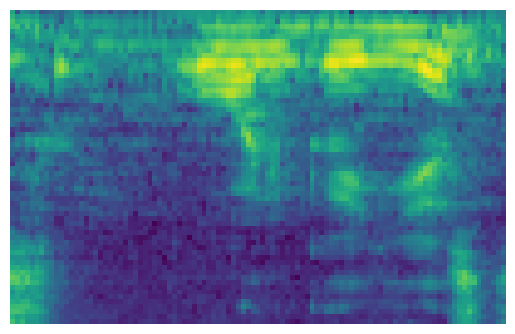

{'sber': 0.03993501, 'joy': 0.015810246, 'afina': 0.003458489, 'salut': 0.012678321, 'filler': 0.9281179}


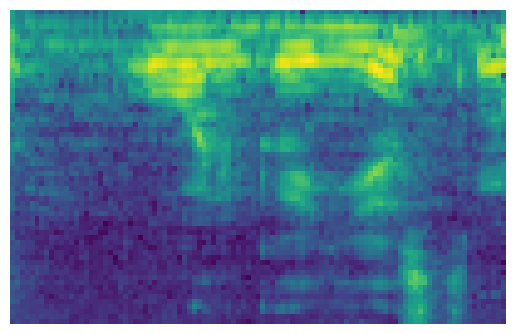

{'sber': 0.09643273, 'joy': 0.2960558, 'afina': 0.0011593716, 'salut': 0.0035999275, 'filler': 0.60275215}


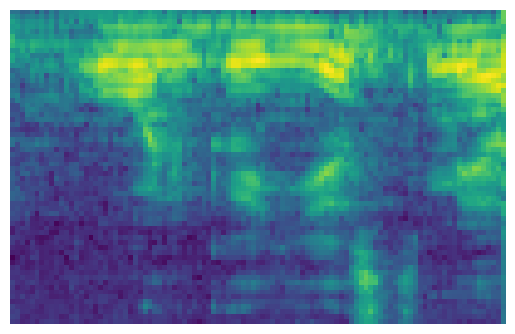

{'sber': 0.15049082, 'joy': 0.009472722, 'afina': 0.015357098, 'salut': 0.00096047926, 'filler': 0.8237189}


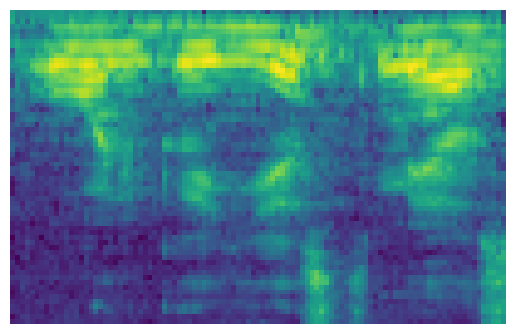

{'sber': 0.18533085, 'joy': 0.016210044, 'afina': 0.0053816536, 'salut': 0.0014502929, 'filler': 0.79162717}


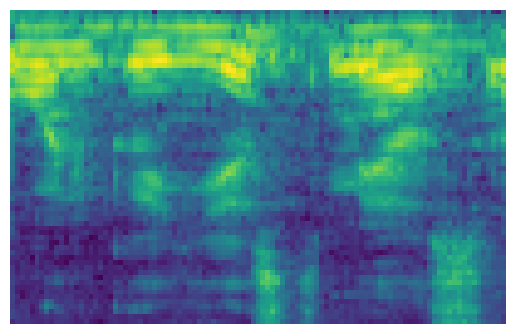

{'sber': 0.3907619, 'joy': 0.049308147, 'afina': 0.009037241, 'salut': 0.0030123747, 'filler': 0.54788035}


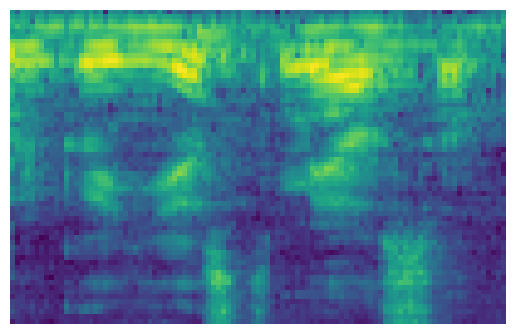

{'sber': 0.0043695304, 'joy': 0.0019935805, 'afina': 0.007901346, 'salut': 0.007325843, 'filler': 0.9784097}


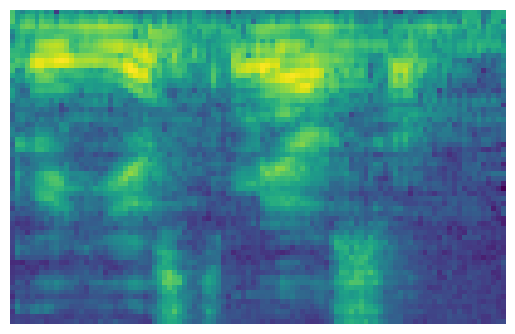

{'sber': 0.023568286, 'joy': 0.0015745723, 'afina': 0.0008641268, 'salut': 0.00029997065, 'filler': 0.973693}


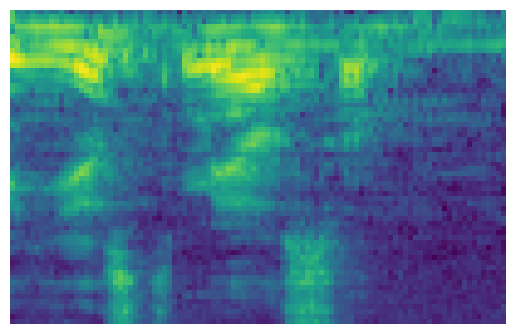

{'sber': 0.3533766, 'joy': 0.015517746, 'afina': 0.033711784, 'salut': 0.013148795, 'filler': 0.58424515}


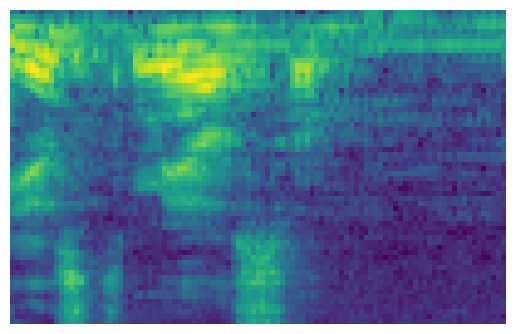

{'sber': 0.13532093, 'joy': 0.04221981, 'afina': 0.008754184, 'salut': 0.1840985, 'filler': 0.6296066}


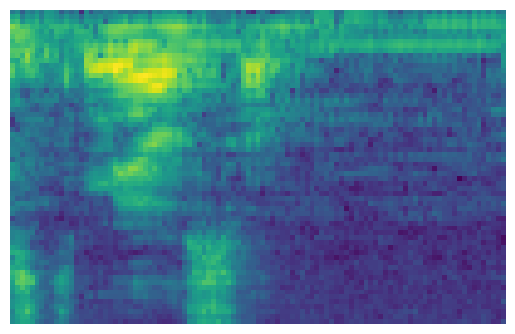

{'sber': 0.0077182422, 'joy': 0.010043663, 'afina': 0.0032900872, 'salut': 0.0051827193, 'filler': 0.97376525}


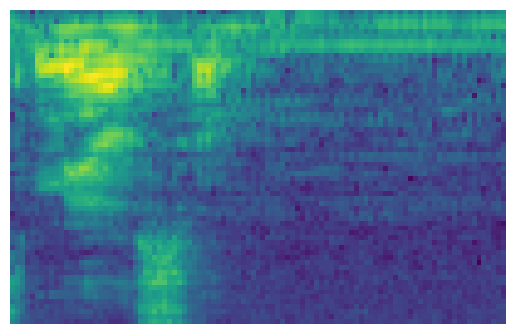

{'sber': 0.0026176646, 'joy': 0.0023061254, 'afina': 0.0087871095, 'salut': 0.005491611, 'filler': 0.98079747}


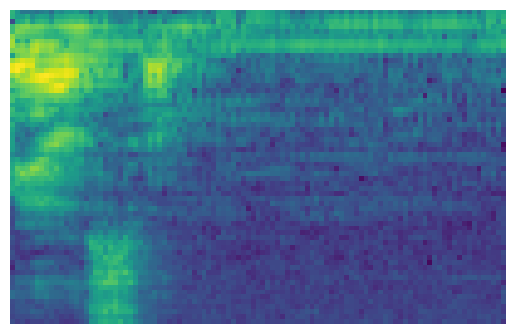

{'sber': 0.022665443, 'joy': 0.07665259, 'afina': 0.045320295, 'salut': 0.094256, 'filler': 0.76110566}


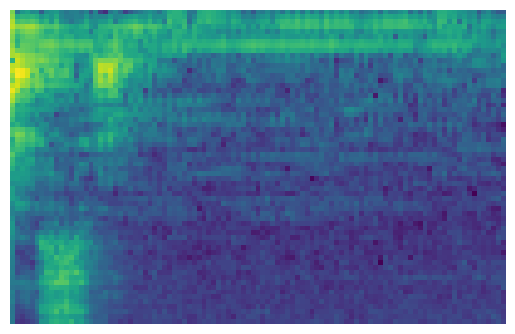

{'sber': 0.07106263, 'joy': 0.1925449, 'afina': 0.04960536, 'salut': 0.2760908, 'filler': 0.4106963}


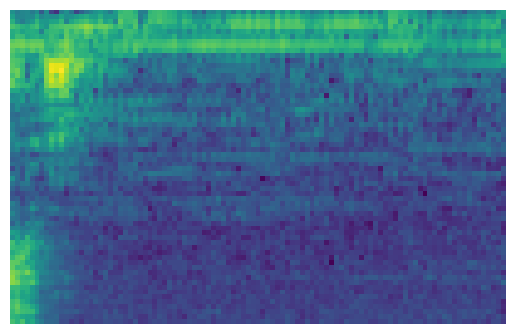

{'sber': 0.003076202, 'joy': 0.004421402, 'afina': 0.010463736, 'salut': 0.012113035, 'filler': 0.9699256}


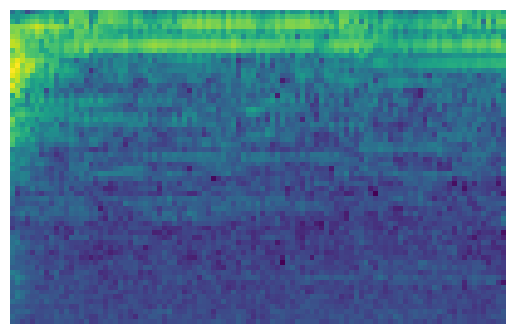

{'sber': 0.0025054764, 'joy': 0.005553624, 'afina': 0.0055490765, 'salut': 0.010092559, 'filler': 0.9762992}


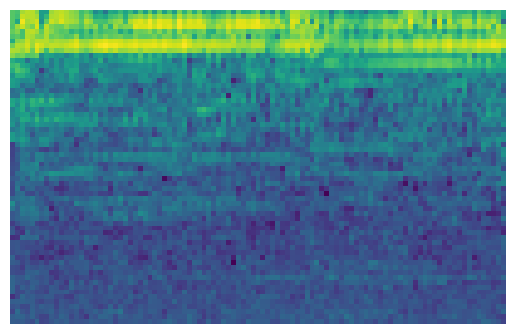

{'sber': 0.055661526, 'joy': 0.18306983, 'afina': 0.07421112, 'salut': 0.1507162, 'filler': 0.5363413}


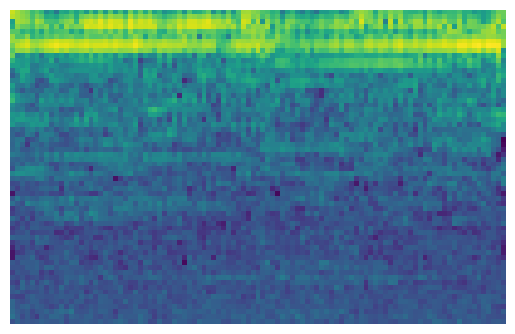

{'sber': 0.032355588, 'joy': 0.06891812, 'afina': 0.06438401, 'salut': 0.08961891, 'filler': 0.7447233}


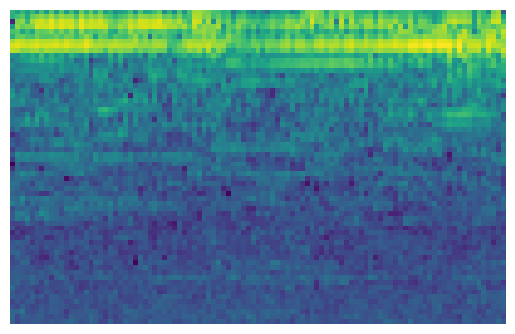

{'sber': 0.0034984206, 'joy': 0.0086671505, 'afina': 0.0067897765, 'salut': 0.013482945, 'filler': 0.9675617}


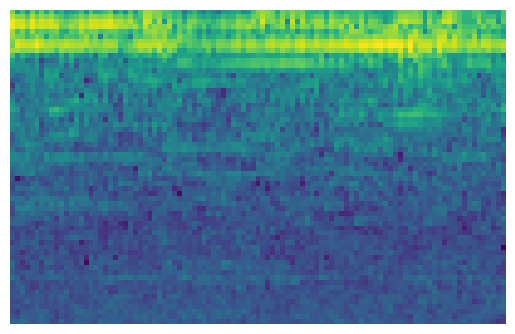

{'sber': 0.0022430005, 'joy': 0.004772678, 'afina': 0.003908063, 'salut': 0.0069658123, 'filler': 0.98211044}


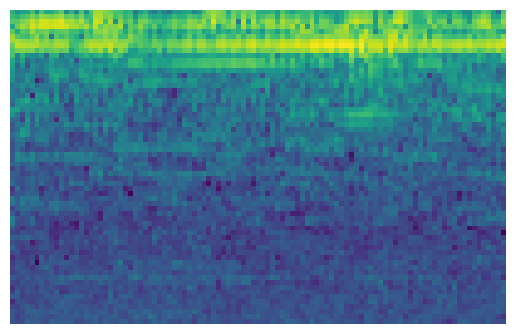

{'sber': 0.015168523, 'joy': 0.03243734, 'afina': 0.025910908, 'salut': 0.040271502, 'filler': 0.8862117}


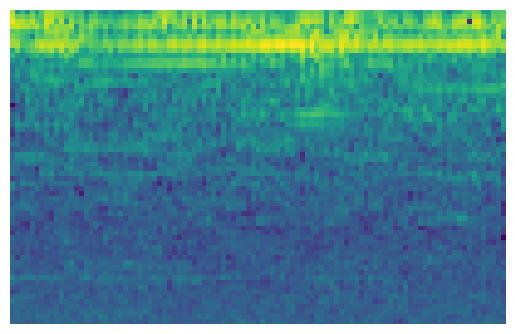

{'sber': 0.040063895, 'joy': 0.08960884, 'afina': 0.059394464, 'salut': 0.09670582, 'filler': 0.714227}


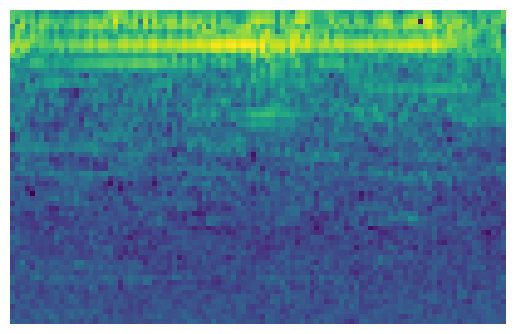

{'sber': 0.038737986, 'joy': 0.09850219, 'afina': 0.046032887, 'salut': 0.090503275, 'filler': 0.72622365}


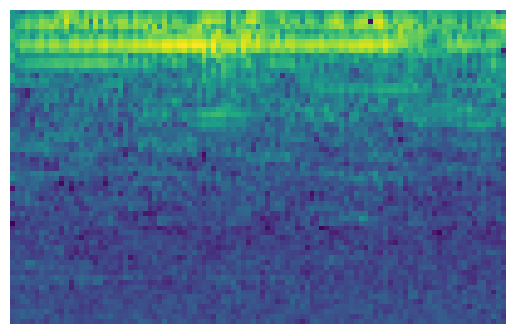

{'sber': 0.010967585, 'joy': 0.018968843, 'afina': 0.014349441, 'salut': 0.022695363, 'filler': 0.93301874}


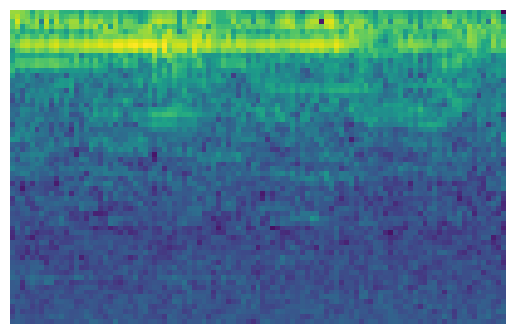

{'sber': 0.009174389, 'joy': 0.0241403, 'afina': 0.010330041, 'salut': 0.02527736, 'filler': 0.9310779}


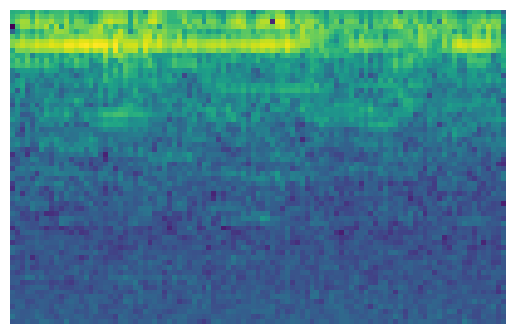

{'sber': 0.014440059, 'joy': 0.033178974, 'afina': 0.020472484, 'salut': 0.042108256, 'filler': 0.88980025}


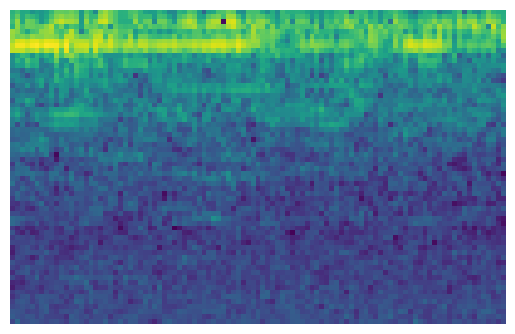

{'sber': 0.016762698, 'joy': 0.039354187, 'afina': 0.019052023, 'salut': 0.04614243, 'filler': 0.8786887}


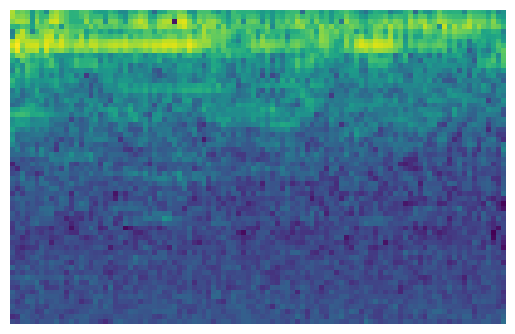

{'sber': 0.028726188, 'joy': 0.031581674, 'afina': 0.027471913, 'salut': 0.029642431, 'filler': 0.8825778}


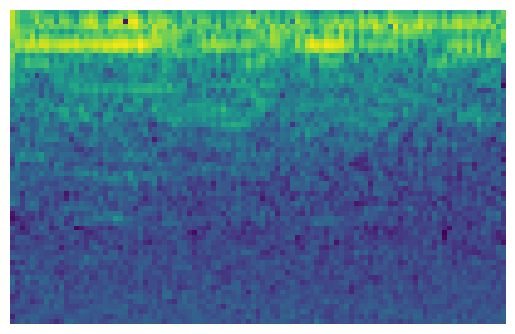

{'sber': 0.021722421, 'joy': 0.044339735, 'afina': 0.022632243, 'salut': 0.046134356, 'filler': 0.86517125}


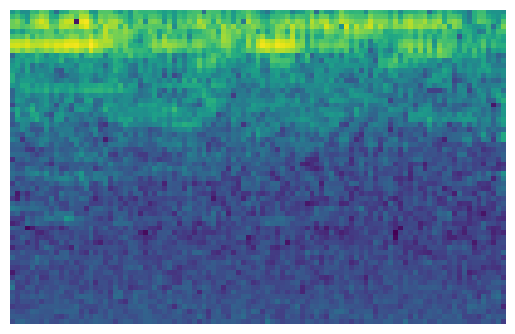

{'sber': 0.0077405293, 'joy': 0.019271653, 'afina': 0.005505329, 'salut': 0.013165941, 'filler': 0.9543166}


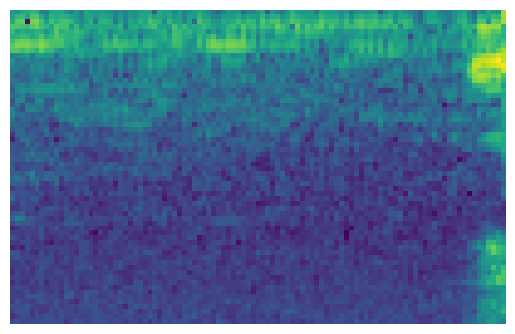

{'sber': 0.06147393, 'joy': 0.09943587, 'afina': 0.041593138, 'salut': 0.04489607, 'filler': 0.75260097}


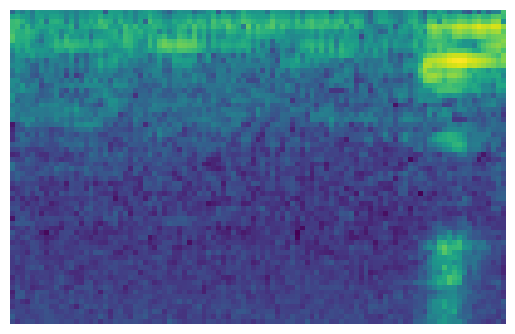

{'sber': 0.42283574, 'joy': 0.4503052, 'afina': 0.0096172355, 'salut': 0.009715723, 'filler': 0.10752609}


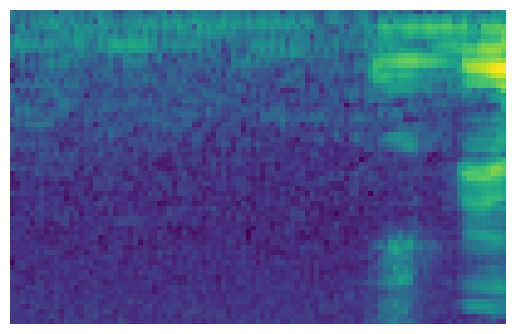

{'sber': 0.28812128, 'joy': 0.67120194, 'afina': 0.0015630253, 'salut': 0.0026668508, 'filler': 0.03644688}


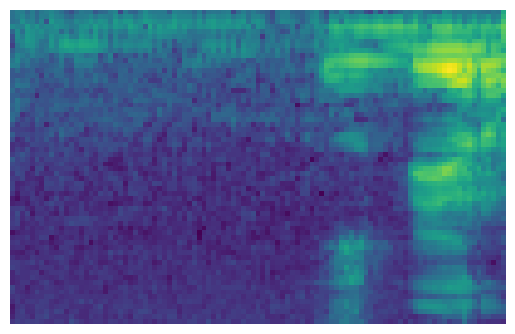

{'sber': 0.12284199, 'joy': 0.69691604, 'afina': 0.0007914046, 'salut': 0.0007311472, 'filler': 0.17871934}


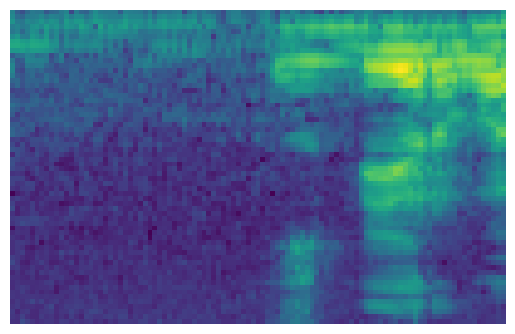

{'sber': 0.46178117, 'joy': 0.4479794, 'afina': 0.0017248427, 'salut': 0.0037090709, 'filler': 0.084805466}


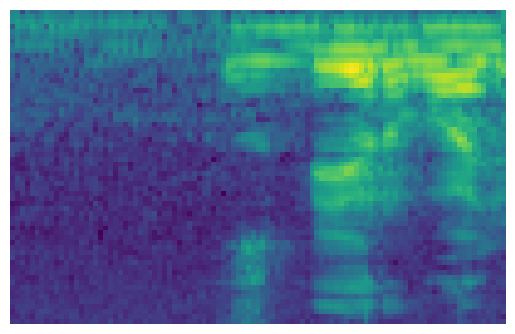

{'sber': 0.7714016, 'joy': 0.12932035, 'afina': 0.0005509573, 'salut': 0.0016972378, 'filler': 0.097029954}


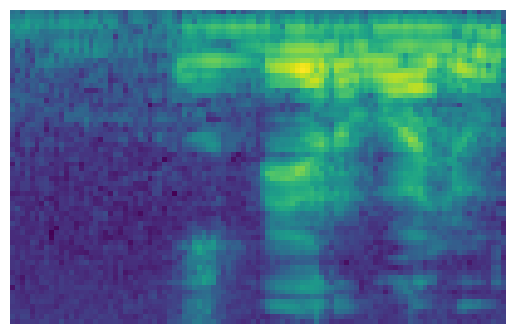

{'sber': 0.09702417, 'joy': 0.87523675, 'afina': 0.00070291344, 'salut': 0.0009780817, 'filler': 0.026058162}


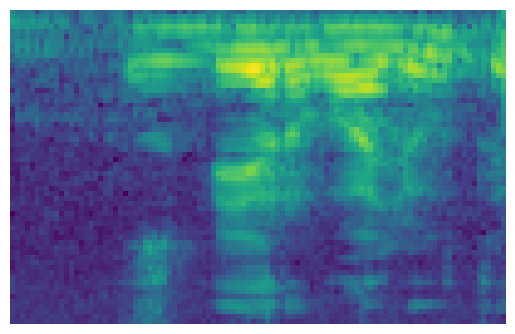

{'sber': 0.1818674, 'joy': 0.7001963, 'afina': 0.00070671184, 'salut': 0.013208499, 'filler': 0.10402098}


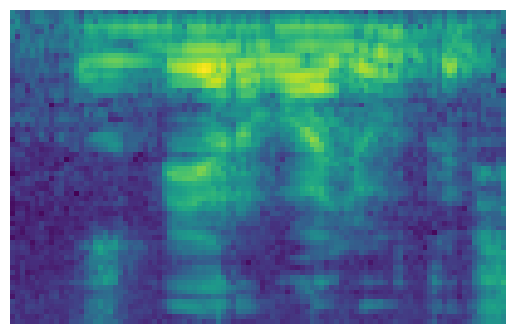

{'sber': 0.66999507, 'joy': 0.19495746, 'afina': 0.0010197537, 'salut': 0.006156868, 'filler': 0.12787081}


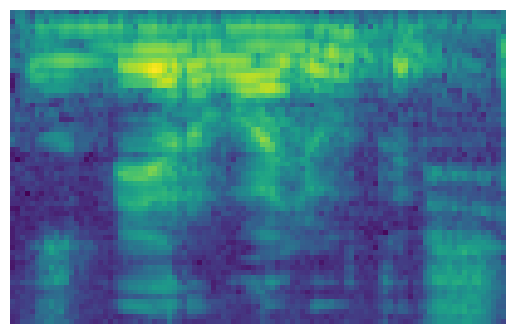

{'sber': 0.69495255, 'joy': 0.051196285, 'afina': 0.00039116514, 'salut': 0.008874696, 'filler': 0.24458535}


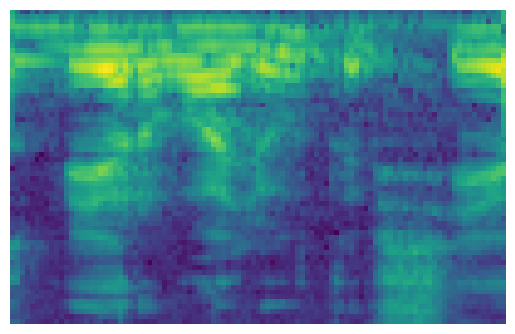

{'sber': 0.42683265, 'joy': 0.22628462, 'afina': 0.0020601007, 'salut': 0.0007160482, 'filler': 0.34410664}


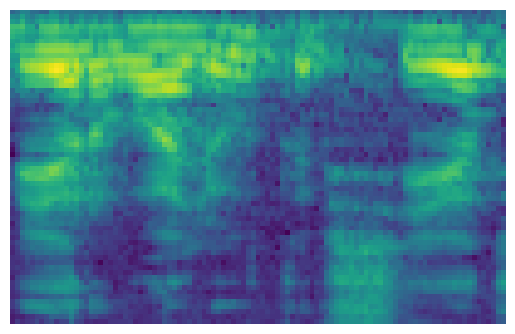

{'sber': 0.039088584, 'joy': 0.019324923, 'afina': 0.003407745, 'salut': 0.07187741, 'filler': 0.86630136}


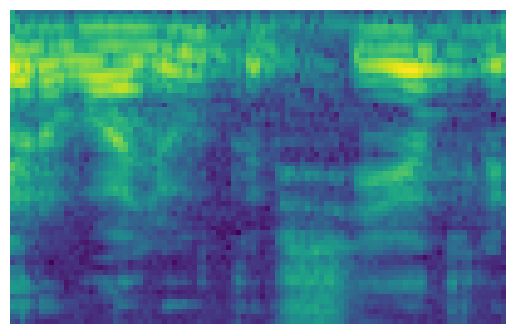

{'sber': 0.36065763, 'joy': 0.010156285, 'afina': 0.012458061, 'salut': 0.00093730283, 'filler': 0.6157907}


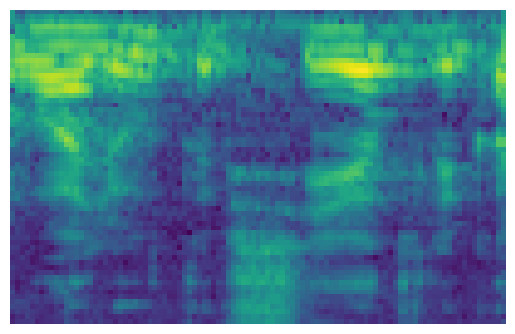

{'sber': 0.048644666, 'joy': 0.009442876, 'afina': 0.0010292388, 'salut': 0.15248133, 'filler': 0.78840184}


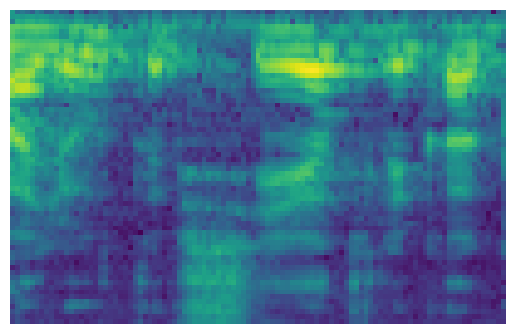

{'sber': 0.18769631, 'joy': 0.011009713, 'afina': 0.0049173958, 'salut': 0.0013484327, 'filler': 0.7950282}


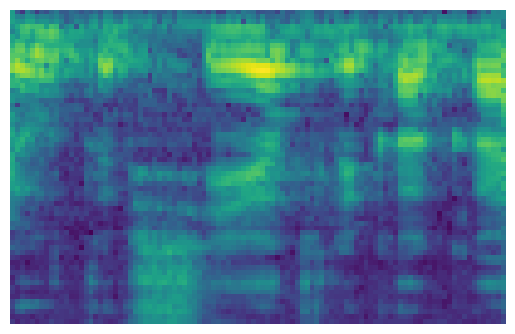

{'sber': 0.07884822, 'joy': 0.0016029818, 'afina': 0.5025205, 'salut': 0.010184534, 'filler': 0.4068438}


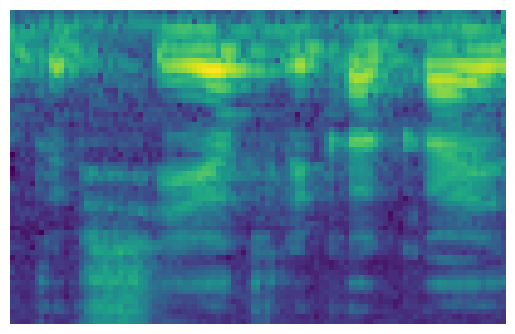

{'sber': 0.7523223, 'joy': 0.0019293452, 'afina': 0.011349031, 'salut': 0.0005936234, 'filler': 0.23380567}


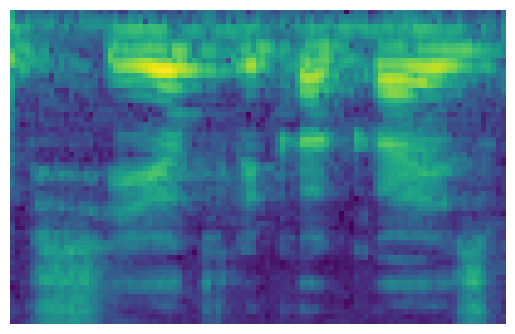

{'sber': 0.531013, 'joy': 0.013706723, 'afina': 0.015488206, 'salut': 0.0069590528, 'filler': 0.432833}


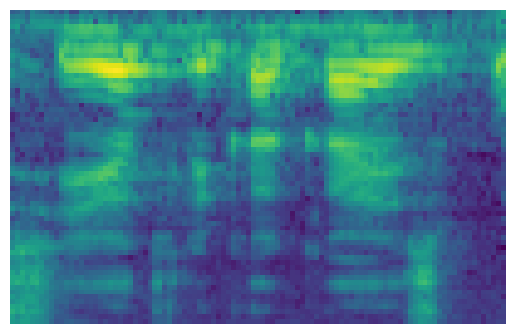

{'sber': 0.08439275, 'joy': 0.0029197675, 'afina': 0.21230002, 'salut': 0.00010529006, 'filler': 0.70028216}


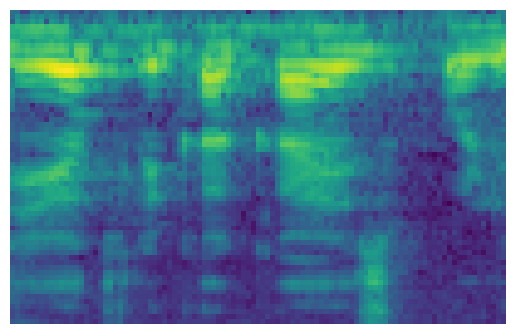

{'sber': 0.009593227, 'joy': 0.007845445, 'afina': 0.29564264, 'salut': 0.07657804, 'filler': 0.61034065}


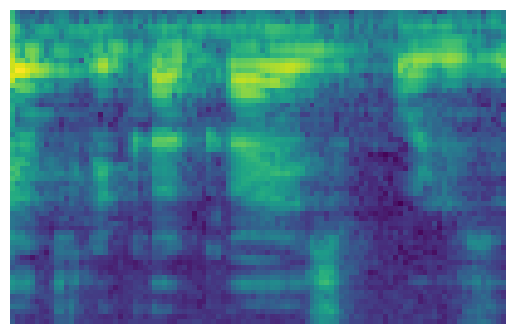

{'sber': 0.028776757, 'joy': 0.019283924, 'afina': 0.41631365, 'salut': 0.09745395, 'filler': 0.4381717}


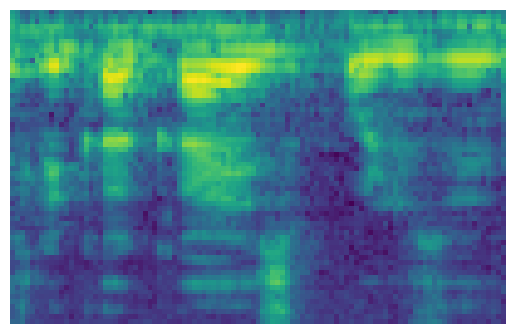

{'sber': 0.0028609387, 'joy': 0.0025510443, 'afina': 0.32717338, 'salut': 0.0019676469, 'filler': 0.66544706}


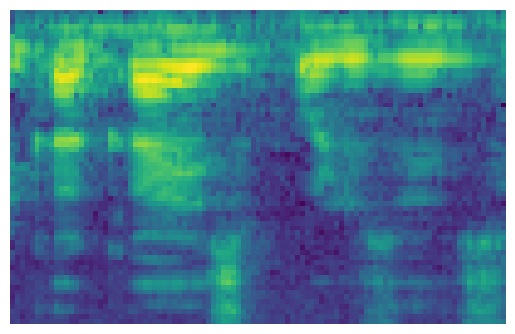

{'sber': 0.0004348089, 'joy': 0.0045694304, 'afina': 0.012333398, 'salut': 0.11003538, 'filler': 0.8726269}


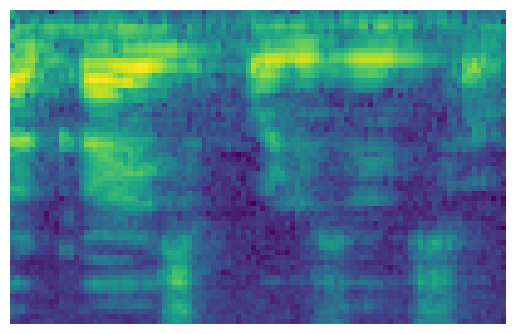

{'sber': 0.0067566107, 'joy': 0.012919209, 'afina': 0.041421242, 'salut': 0.07563445, 'filler': 0.8632685}


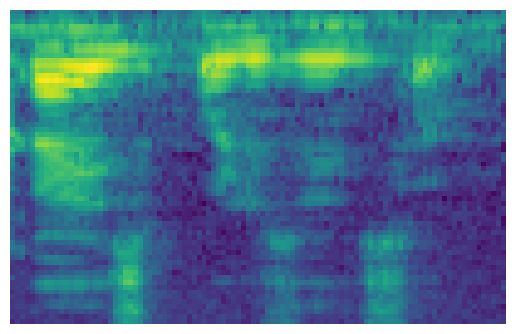

{'sber': 0.004704886, 'joy': 0.00787925, 'afina': 0.029151512, 'salut': 0.008288619, 'filler': 0.9499758}


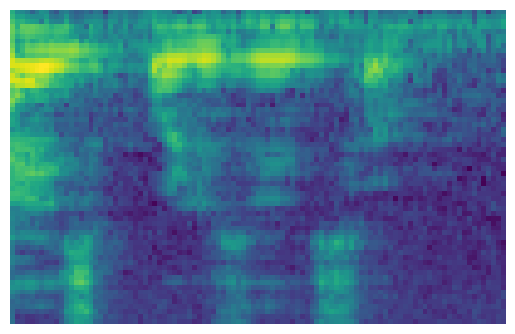

{'sber': 0.004545543, 'joy': 0.008660136, 'afina': 0.001716478, 'salut': 0.015366349, 'filler': 0.9697114}


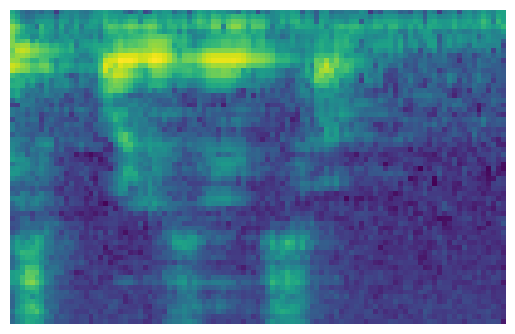

{'sber': 0.0016521587, 'joy': 0.016591392, 'afina': 0.0023151303, 'salut': 0.041418448, 'filler': 0.93802285}


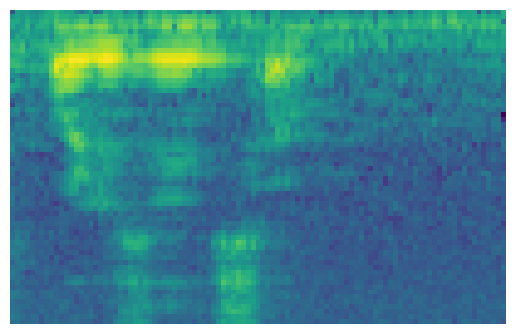

{'sber': 0.008174993, 'joy': 0.04476393, 'afina': 0.012519983, 'salut': 0.07148184, 'filler': 0.8630593}


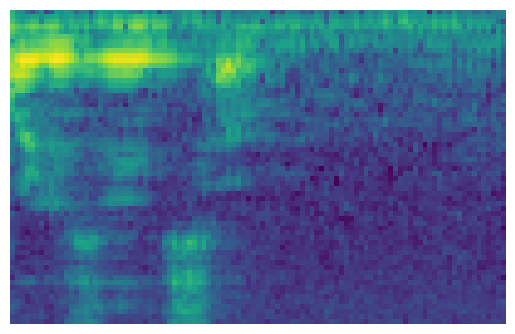

{'sber': 0.006927722, 'joy': 0.01218208, 'afina': 0.008094011, 'salut': 0.008797188, 'filler': 0.963999}


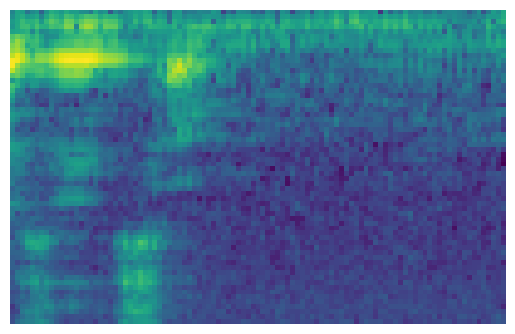

{'sber': 0.018110016, 'joy': 0.040835515, 'afina': 0.019944971, 'salut': 0.037226737, 'filler': 0.88388276}


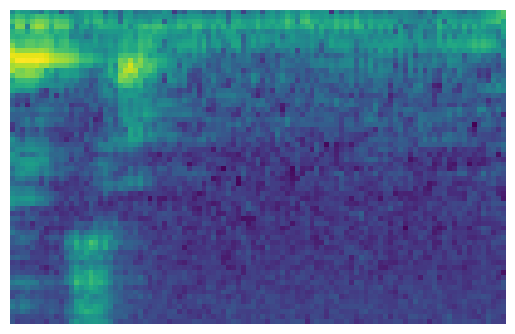

{'sber': 0.08297342, 'joy': 0.16311172, 'afina': 0.063705966, 'salut': 0.10325301, 'filler': 0.5869559}


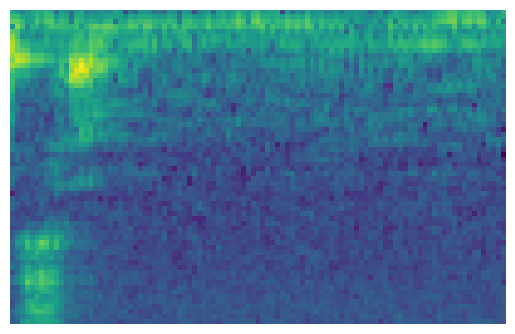

{'sber': 0.015175121, 'joy': 0.01842694, 'afina': 0.008450779, 'salut': 0.01499247, 'filler': 0.9429547}


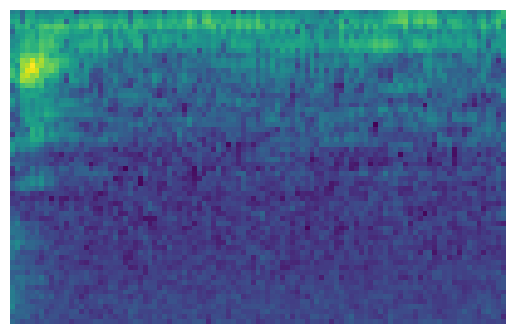

{'sber': 0.014645812, 'joy': 0.01401312, 'afina': 0.008332491, 'salut': 0.01151633, 'filler': 0.95149225}


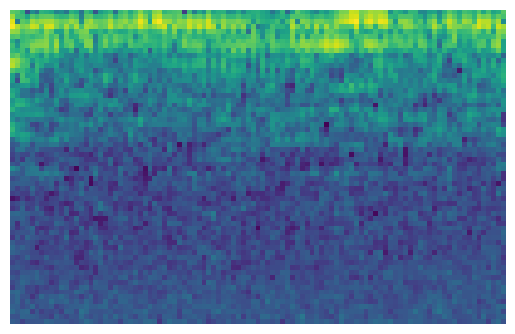

{'sber': 0.118435465, 'joy': 0.19091763, 'afina': 0.05378715, 'salut': 0.08706545, 'filler': 0.5497943}


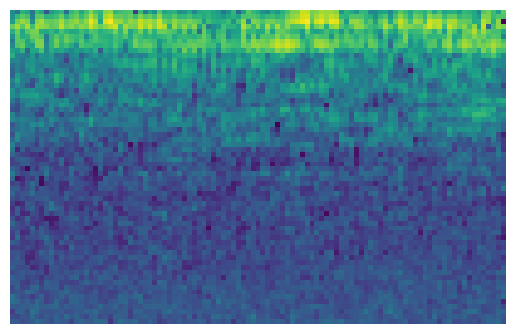

{'sber': 0.15504919, 'joy': 0.25005955, 'afina': 0.10535566, 'salut': 0.13829726, 'filler': 0.35123825}


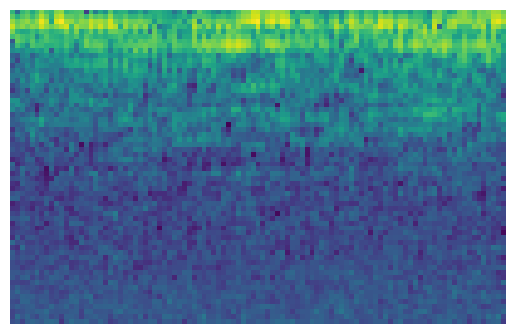

{'sber': 0.038786404, 'joy': 0.033879146, 'afina': 0.021753207, 'salut': 0.024520792, 'filler': 0.8810604}


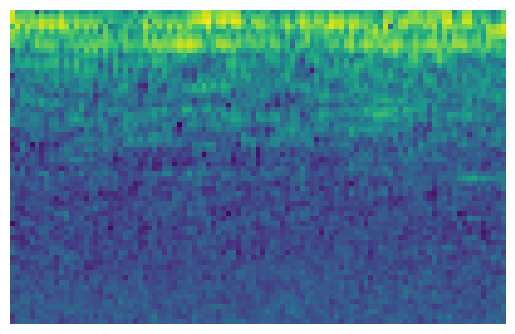

{'sber': 0.035321306, 'joy': 0.049773965, 'afina': 0.01897415, 'salut': 0.034871984, 'filler': 0.86105853}


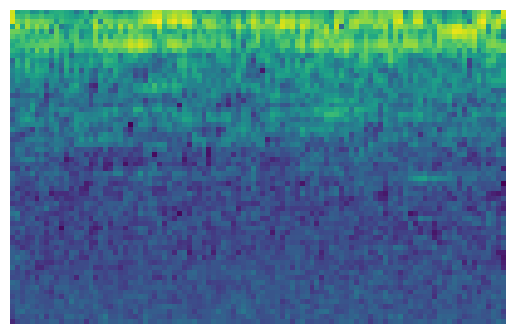

{'sber': 0.085607484, 'joy': 0.13209243, 'afina': 0.05714766, 'salut': 0.09509229, 'filler': 0.63006014}


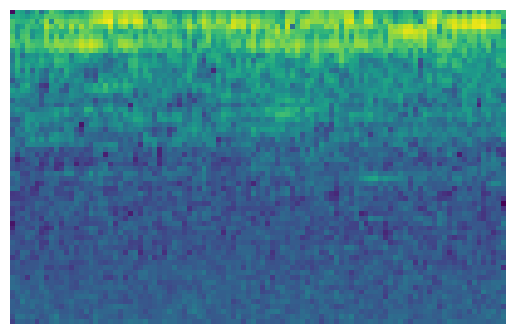

{'sber': 0.042146243, 'joy': 0.039279148, 'afina': 0.018445155, 'salut': 0.022154687, 'filler': 0.87797475}


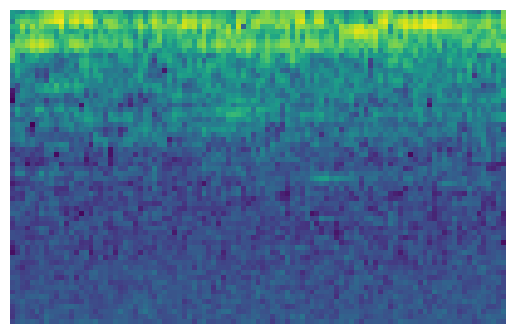

{'sber': 0.036439147, 'joy': 0.030912329, 'afina': 0.020261504, 'salut': 0.024222437, 'filler': 0.8881646}


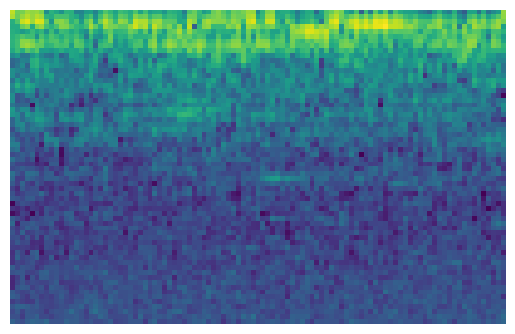

{'sber': 0.06671017, 'joy': 0.085172996, 'afina': 0.046368662, 'salut': 0.06504416, 'filler': 0.736704}


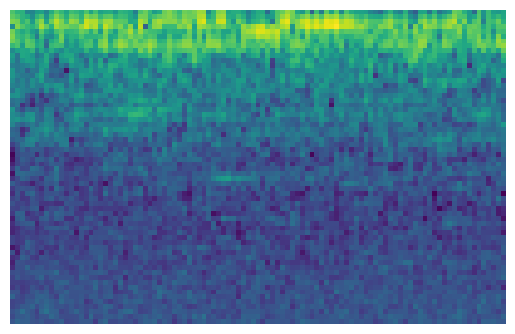

{'sber': 0.019842105, 'joy': 0.01750957, 'afina': 0.01124491, 'salut': 0.014192318, 'filler': 0.9372111}


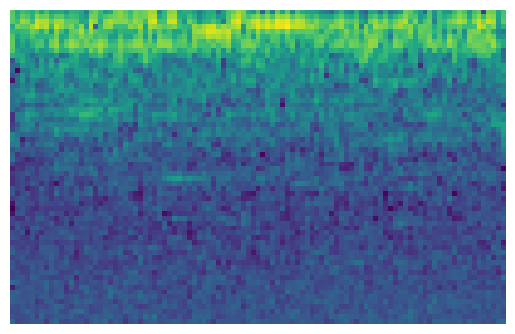

{'sber': 0.013192329, 'joy': 0.011177301, 'afina': 0.0055783815, 'salut': 0.007386438, 'filler': 0.96266556}


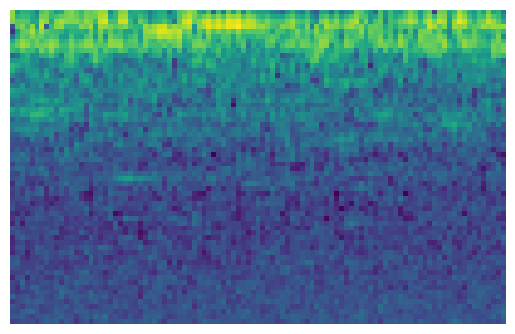

{'sber': 0.095543705, 'joy': 0.1357172, 'afina': 0.052728053, 'salut': 0.080443054, 'filler': 0.63556796}


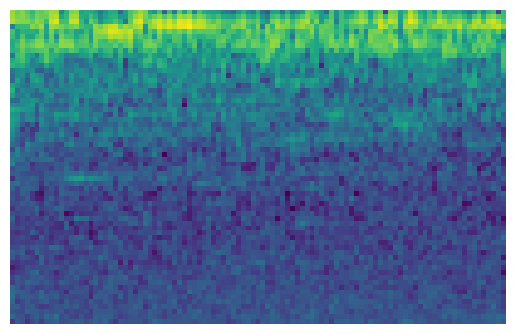

{'sber': 0.10771214, 'joy': 0.20601799, 'afina': 0.063401386, 'salut': 0.113510504, 'filler': 0.509358}


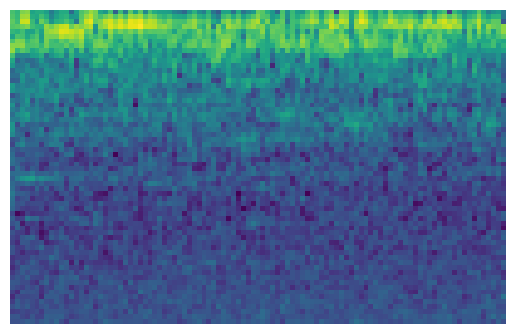

{'sber': 0.019850174, 'joy': 0.016407233, 'afina': 0.012294732, 'salut': 0.014536154, 'filler': 0.9369117}


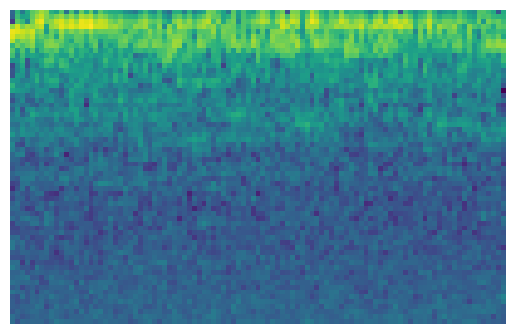

{'sber': 0.018248897, 'joy': 0.014512594, 'afina': 0.01126322, 'salut': 0.011862491, 'filler': 0.9441128}


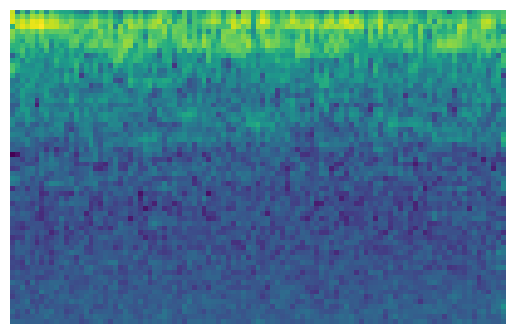

{'sber': 0.040498897, 'joy': 0.1607352, 'afina': 0.020669088, 'salut': 0.57612085, 'filler': 0.20197597}


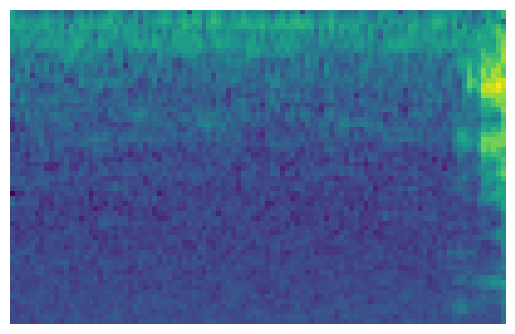

{'sber': 0.030292647, 'joy': 0.07913401, 'afina': 0.03659226, 'salut': 0.17565574, 'filler': 0.67832536}


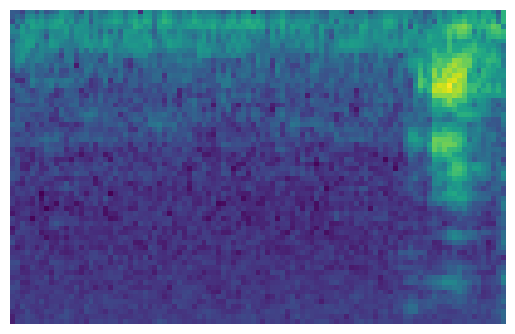

{'sber': 0.04600173, 'joy': 0.05533093, 'afina': 0.094208054, 'salut': 0.19914448, 'filler': 0.60531485}


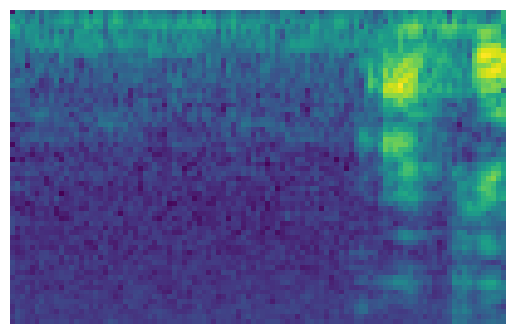

{'sber': 0.00802775, 'joy': 0.0045020343, 'afina': 0.06576878, 'salut': 0.14530267, 'filler': 0.7763987}


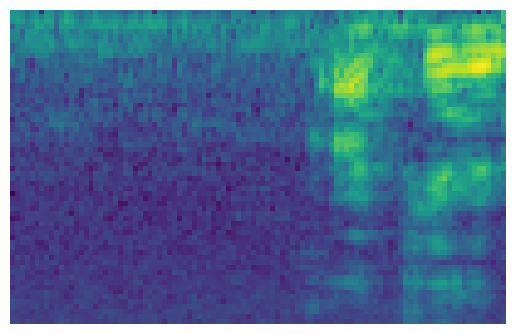

{'sber': 0.0051741507, 'joy': 0.01195687, 'afina': 0.04612958, 'salut': 0.46831194, 'filler': 0.46842745}


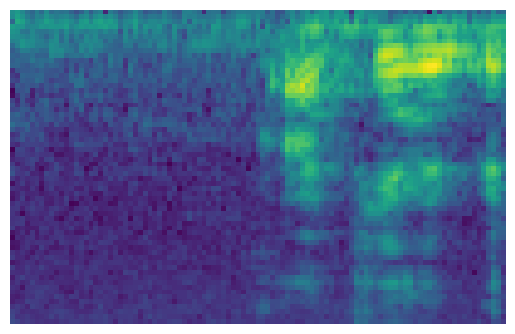

{'sber': 0.010569002, 'joy': 0.048226357, 'afina': 0.20076814, 'salut': 0.45373, 'filler': 0.28670645}


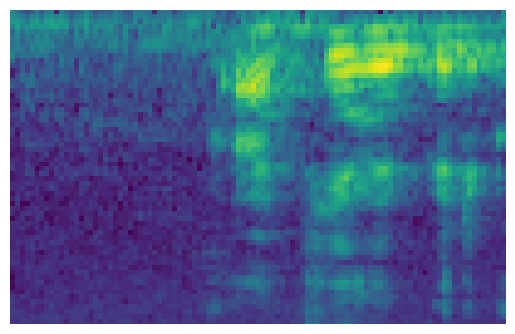

{'sber': 0.008709379, 'joy': 0.046625417, 'afina': 0.14679639, 'salut': 0.14179814, 'filler': 0.65607065}


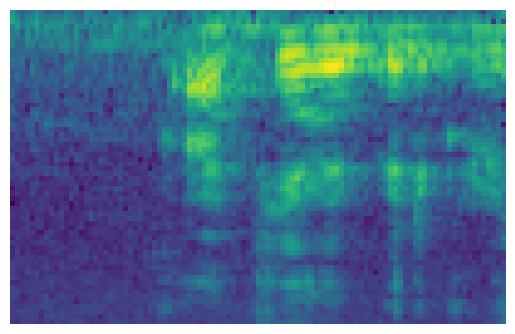

{'sber': 0.0049921735, 'joy': 0.01132024, 'afina': 0.59745926, 'salut': 0.09502745, 'filler': 0.29120088}


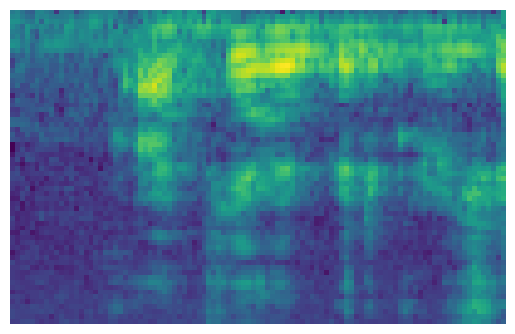

{'sber': 0.00018418212, 'joy': 0.00515609, 'afina': 0.052310936, 'salut': 0.2986336, 'filler': 0.6437152}


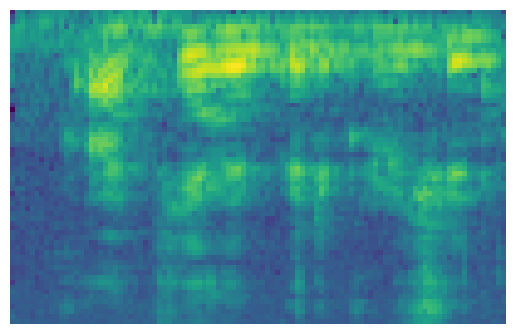

{'sber': 0.01574185, 'joy': 0.008872009, 'afina': 0.21434776, 'salut': 0.010585252, 'filler': 0.7504532}


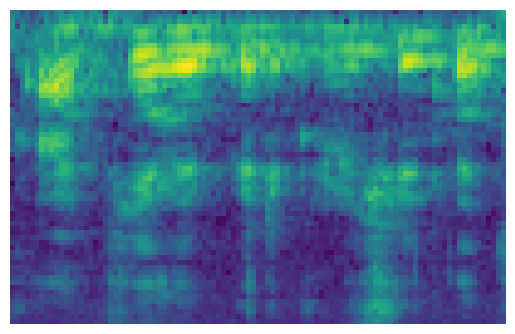

{'sber': 0.0015111044, 'joy': 0.010998436, 'afina': 0.6981412, 'salut': 0.00229266, 'filler': 0.2870566}


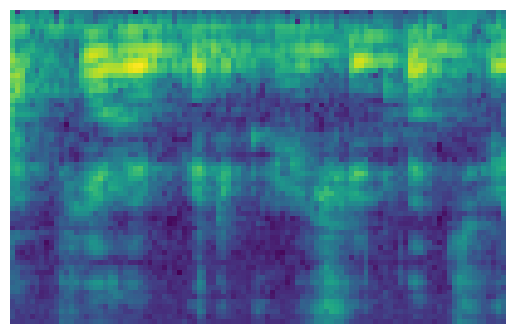

{'sber': 0.0072864722, 'joy': 0.23080064, 'afina': 0.024933241, 'salut': 0.003074847, 'filler': 0.7339048}


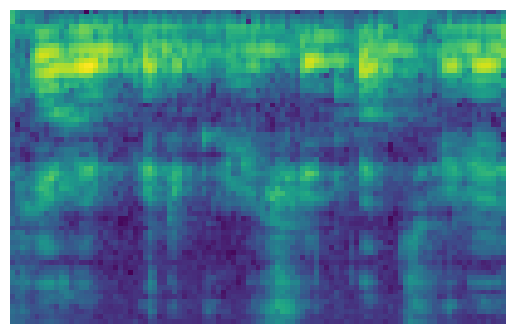

{'sber': 0.00064136, 'joy': 0.08565418, 'afina': 0.0050298744, 'salut': 0.0038562533, 'filler': 0.90481836}


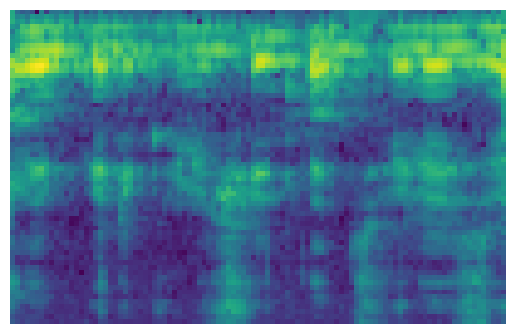

{'sber': 0.010159705, 'joy': 0.5572663, 'afina': 0.010314271, 'salut': 0.00016174225, 'filler': 0.42209798}


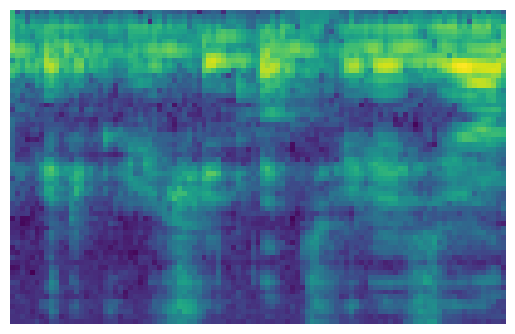

{'sber': 0.049754802, 'joy': 0.30109325, 'afina': 0.011319317, 'salut': 0.0005079373, 'filler': 0.6373247}


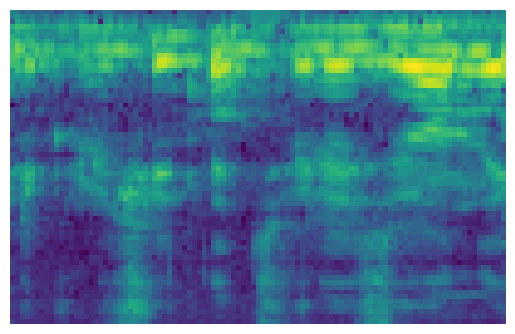

{'sber': 0.0018607696, 'joy': 0.52739, 'afina': 0.004278048, 'salut': 0.0010244428, 'filler': 0.4654467}


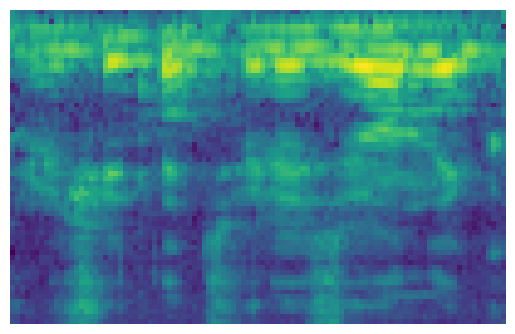

{'sber': 0.004451046, 'joy': 0.11859296, 'afina': 0.0060197646, 'salut': 0.04226355, 'filler': 0.8286727}


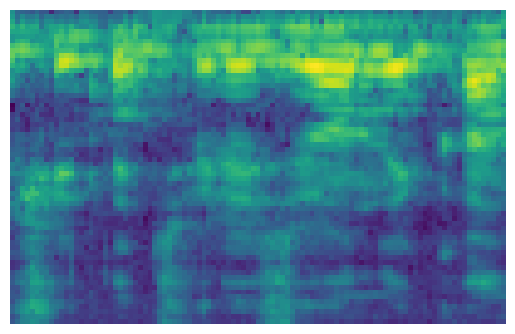

{'sber': 0.006116198, 'joy': 0.15975447, 'afina': 0.011765256, 'salut': 0.0026684892, 'filler': 0.8196956}


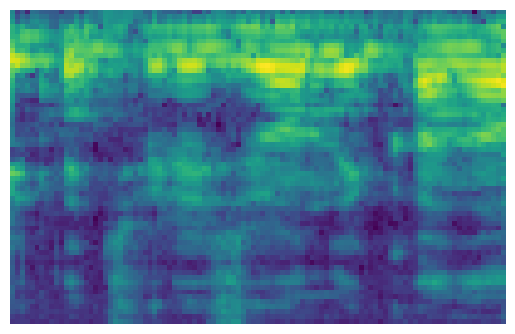

{'sber': 0.036901683, 'joy': 0.0719643, 'afina': 0.027442174, 'salut': 0.0042106807, 'filler': 0.85948116}


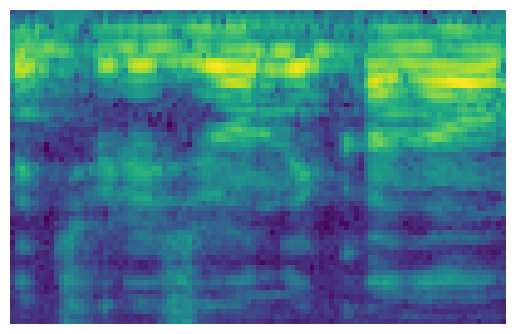

{'sber': 0.013355368, 'joy': 0.029550176, 'afina': 0.007948534, 'salut': 0.119615, 'filler': 0.8295309}


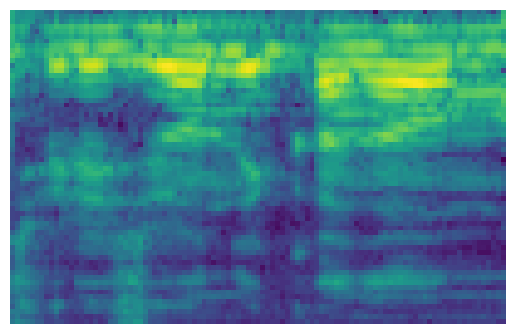

{'sber': 0.012269204, 'joy': 0.0071588773, 'afina': 0.008710047, 'salut': 0.057566937, 'filler': 0.9142949}


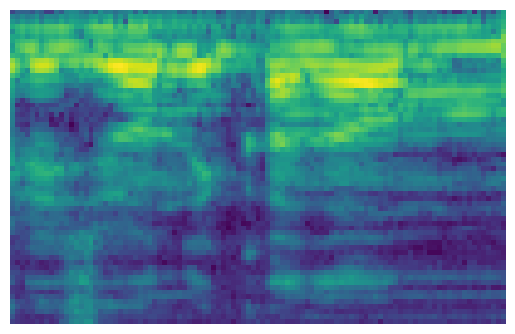

{'sber': 0.016409509, 'joy': 0.03674407, 'afina': 0.008328062, 'salut': 0.04304194, 'filler': 0.8954764}


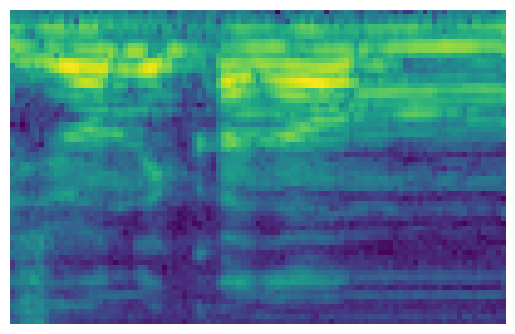

{'sber': 0.008627936, 'joy': 0.003218183, 'afina': 0.002381072, 'salut': 0.026972642, 'filler': 0.9588002}


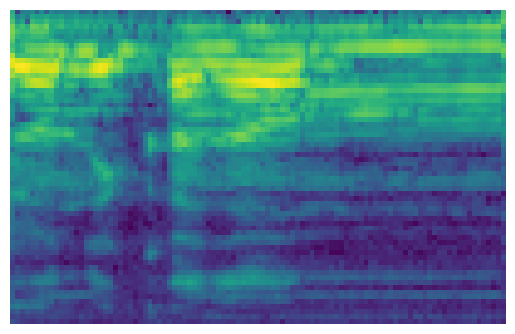

{'sber': 0.0063398345, 'joy': 0.0027794682, 'afina': 0.0010037697, 'salut': 0.008807976, 'filler': 0.9810689}


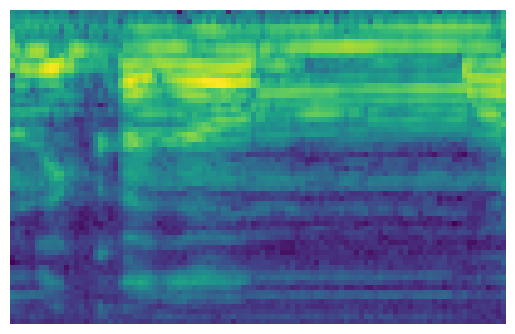

{'sber': 0.0017087306, 'joy': 0.0016336355, 'afina': 0.00035869514, 'salut': 0.024717031, 'filler': 0.9715819}


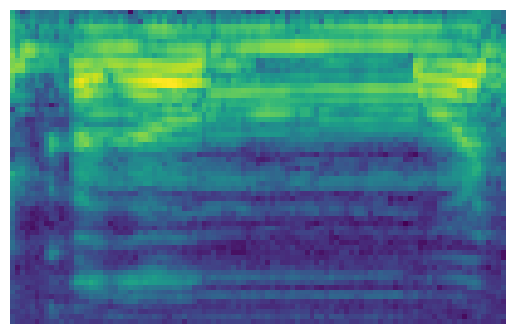

{'sber': 0.00073702785, 'joy': 0.0007651929, 'afina': 0.021366479, 'salut': 0.012311118, 'filler': 0.9648202}


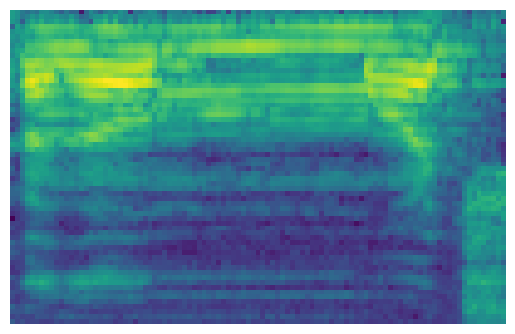

{'sber': 0.0012557063, 'joy': 0.0005626019, 'afina': 0.0010443254, 'salut': 0.0030056771, 'filler': 0.9941316}


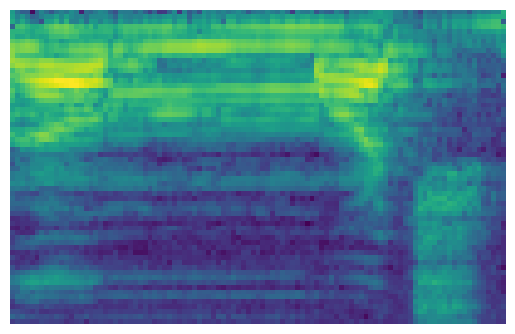

{'sber': 0.000329127, 'joy': 0.0001949695, 'afina': 0.0001740012, 'salut': 0.00032693654, 'filler': 0.99897504}


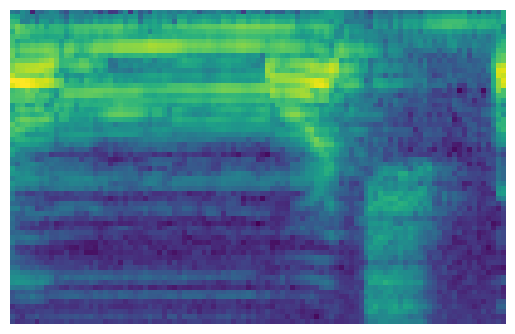

{'sber': 0.0014504665, 'joy': 0.0007879047, 'afina': 0.0046019303, 'salut': 0.012979808, 'filler': 0.9801799}


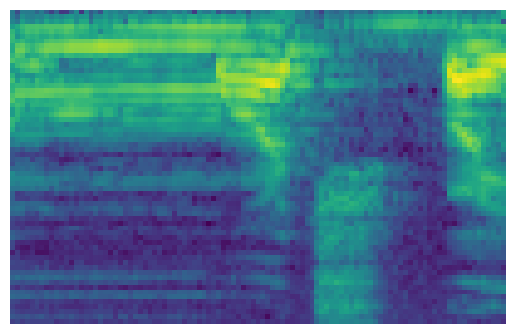

{'sber': 0.0010738029, 'joy': 0.0007317942, 'afina': 0.033322606, 'salut': 0.001077683, 'filler': 0.9637942}


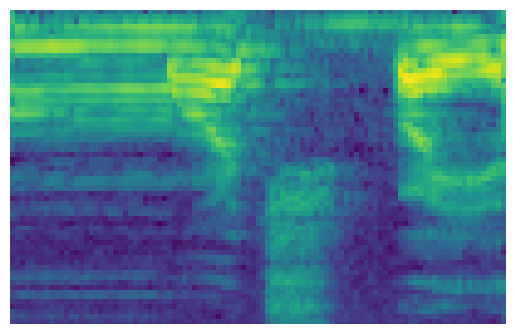

{'sber': 0.00067692745, 'joy': 0.0003663143, 'afina': 0.1327125, 'salut': 0.00082016876, 'filler': 0.86542416}


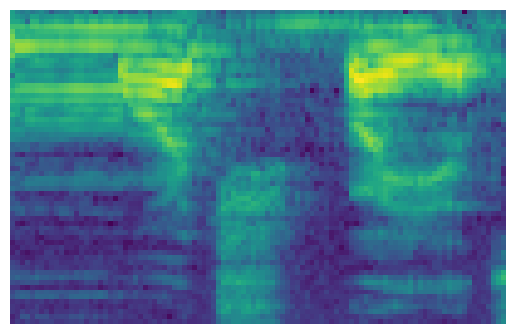

{'sber': 6.0918966e-05, 'joy': 3.898007e-05, 'afina': 0.0038948988, 'salut': 0.00024786917, 'filler': 0.9957573}


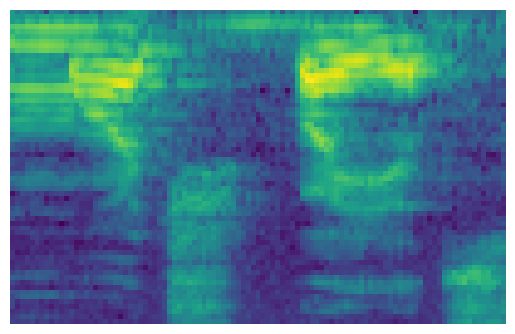

{'sber': 0.0002937588, 'joy': 0.00011399748, 'afina': 0.012372174, 'salut': 0.0059131444, 'filler': 0.9813069}


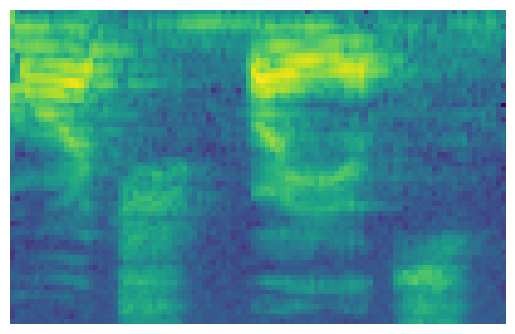

{'sber': 0.0053773466, 'joy': 0.00055042707, 'afina': 0.0990903, 'salut': 0.005857827, 'filler': 0.88912416}


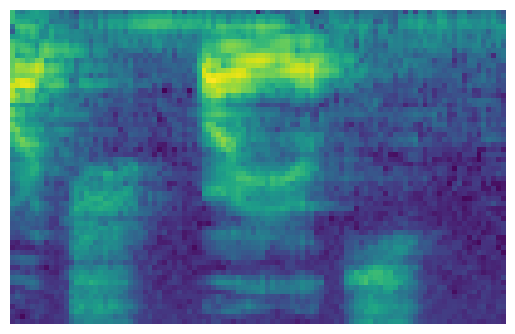

{'sber': 0.05587706, 'joy': 0.004086288, 'afina': 0.083515145, 'salut': 0.06970835, 'filler': 0.78681314}


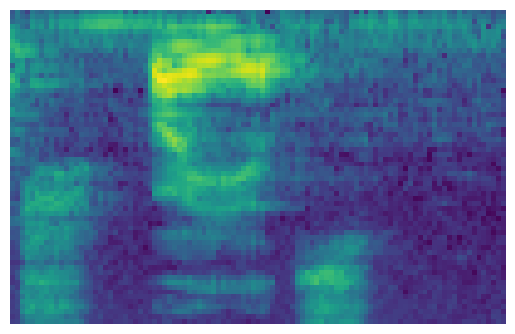

{'sber': 0.011218747, 'joy': 0.0008657588, 'afina': 0.0037382238, 'salut': 0.01172596, 'filler': 0.97245127}


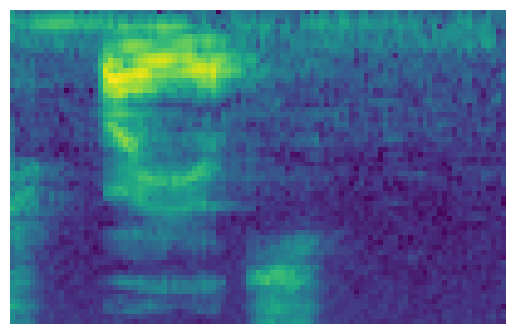

In [30]:
test_wav_path = "./data/8b427e83c196b517cd240822a18ba698.wav"

wav, sr = torchaudio.load(test_wav_path)

window_size = sr
step_size = sr // 10

chunks = (wav.shape[1] - window_size) // step_size

probs = []

for i in range(chunks):
    wav_segment = wav[:,i*step_size:i*step_size + window_size]
    spec_segment = val_transform(wav_segment)
    with torch.no_grad():
        logprobs = model(spec_segment.to(conf.device)).cpu()[0].numpy()
    probs.append(logprobs)
    print({conf.idx_to_keyword[i]: np.exp(prob) for i, prob in enumerate(logprobs)})
    plt.axis('off')
    plt.imshow(spec_segment[0])
    plt.show()

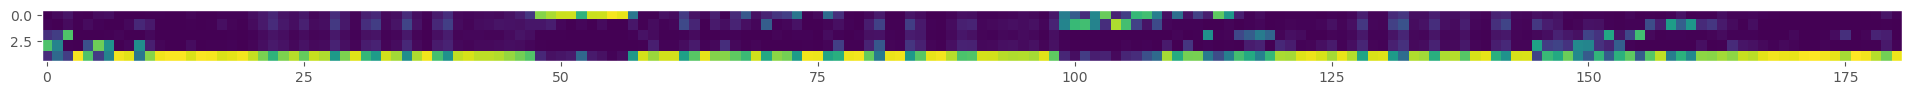

In [31]:
prob_matrix = np.exp(np.vstack(probs).T)

plt.figure(figsize=(24,6))
plt.grid()
plt.imshow(prob_matrix)
plt.savefig('long_audio_prob_matrix.png', dpi=300)

In [32]:
def rle_borders(data: List[int]) -> List[Tuple[int]]:
    res = []
    
    n = len(data)
    i = 0
    
    while i < n:
        prev = last = data[i]
        while i < n and data[i] - last <= 1:
            last = data[i]
            i += 1
        res.append((prev, last))
        
    return res

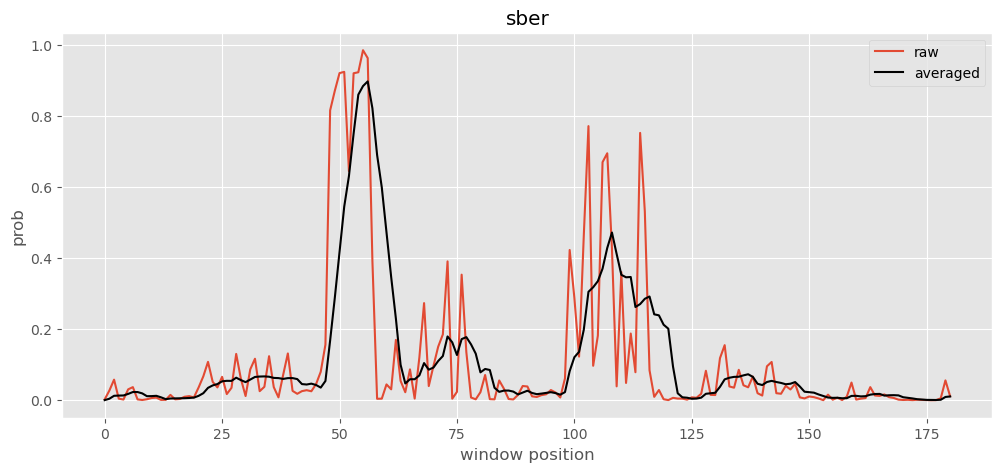

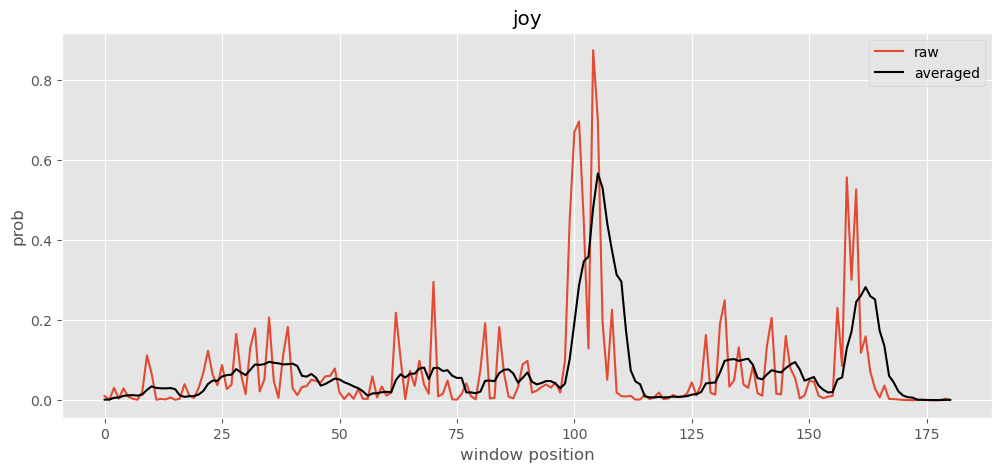

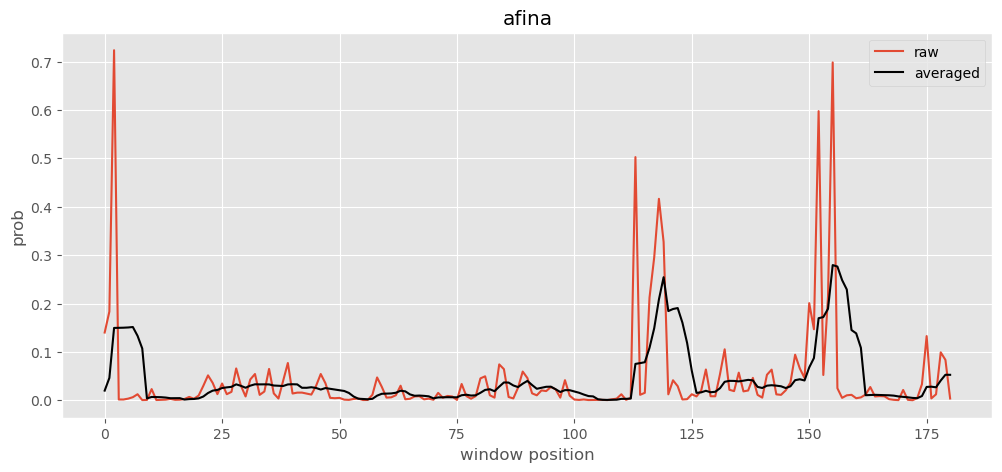

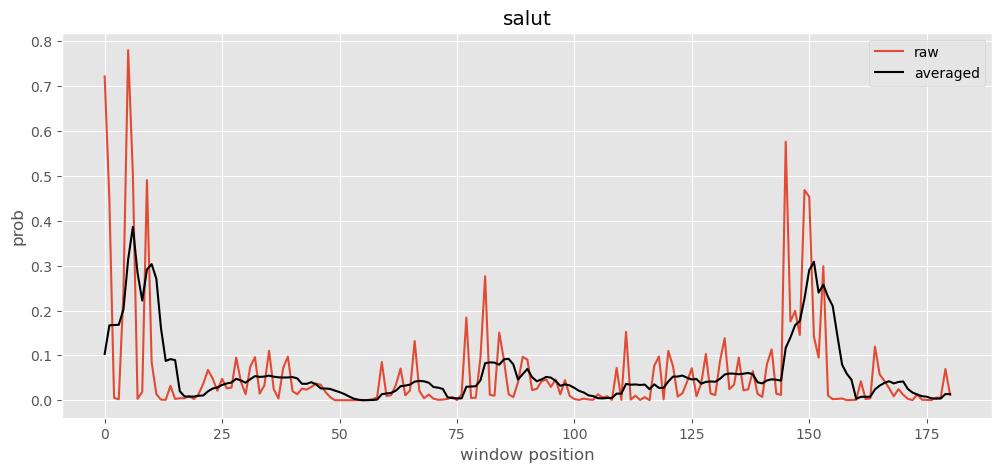

In [33]:
L = 7
th = 0.5

activation_ids = []

window_filter = np.ones(L)
window_filter /= L

for idx in range(4):

    smoothed = np.convolve(
        np.pad(prob_matrix[idx], pad_width=(L - 1, 0), constant_values=(0,)),
        window_filter,
        mode='valid'
    )
    plt.figure(figsize=(12,5))
    plt.title(conf.idx_to_keyword[idx])
    plt.plot(prob_matrix[idx], label='raw')
    plt.plot(smoothed, color='k', label='averaged')
    plt.xlabel('window position')
    plt.ylabel('prob')
    plt.legend()
    plt.show()
    activation_ids.append(np.where(smoothed > th)[0].tolist())

In [34]:
ipd.Audio(wav, rate=conf.sample_rate)

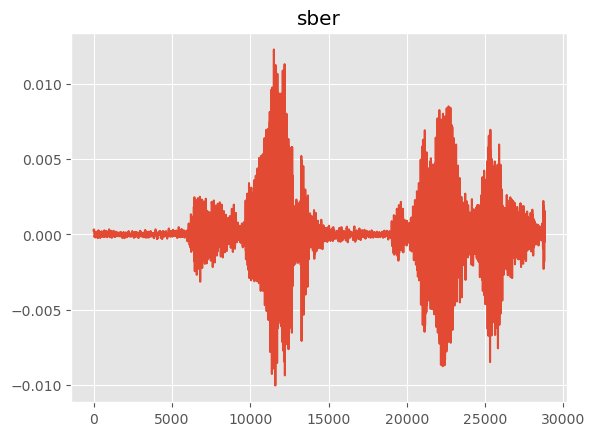

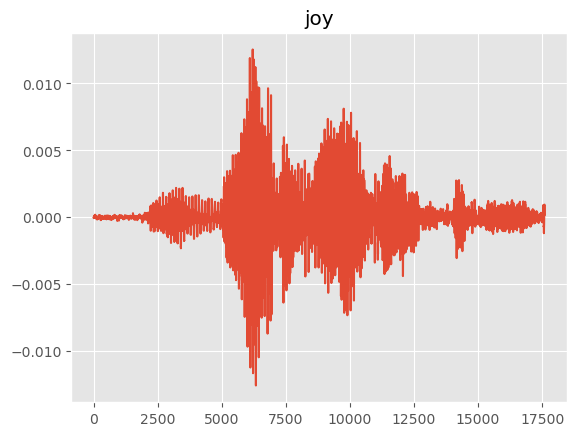

In [35]:
for idx, activations in enumerate(activation_ids):
    
    for start_frame, end_frame in rle_borders(activations):
        
        ipd.display(ipd.Audio(wav[0,start_frame*step_size:end_frame*step_size + window_size], rate=conf.sample_rate))
        plt.title(conf.idx_to_keyword[idx])
        plt.plot(wav[0,start_frame*step_size:end_frame*step_size + window_size])
        plt.show();
        